## Problem Statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn.

In this competition, your goal is to build a machine learning model that is able to predict churning customers based on the features provided for their usage.

### Customer behaviour during churn:

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

## Data Import

In [1]:
# Importing Necessary Libraries.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA

### Make a pipeline
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Set environment settings
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_colwidth', 1000)

In [3]:
# Reading the dataset

telecom_df = pd.read_csv("train.csv")
telecom_unseen_df = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print("Dimension of the training dataset is", telecom_df.shape)
print("Dimension of the unseen dataset is", telecom_unseen_df.shape)
print("Dimension of the sample dataset is", sample.shape)
print("Dimension of the data dictionary is", data_dict.shape)

Dimension of the training dataset is (69999, 172)
Dimension of the unseen dataset is (30000, 171)
Dimension of the sample dataset is (30000, 2)
Dimension of the data dictionary is (36, 2)


In [4]:
# Inspecting the train dataset
telecom_df.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [5]:
# Statistics summary of the train dataset
telecom_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,69999.0,34999.000000,20207.115084,0.0,17499.5,34999.0,52498.5,69998.00
circle_id,69999.0,109.000000,0.000000,109.0,109.0,109.0,109.0,109.00
loc_og_t2o_mou,69297.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00
std_og_t2o_mou,69297.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00
loc_ic_t2o_mou,69297.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...
aon,69999.0,1220.639709,952.426321,180.0,468.0,868.0,1813.0,4337.00
aug_vbc_3g,69999.0,68.108597,269.328659,0.0,0.0,0.0,0.0,12916.22
jul_vbc_3g,69999.0,65.935830,267.899034,0.0,0.0,0.0,0.0,9165.60
jun_vbc_3g,69999.0,60.076740,257.226810,0.0,0.0,0.0,0.0,11166.21


## Data Cleaning and Preparation

### Checking the columns with single unique value

In [6]:
cols_with_single_value = []
for col in telecom_df.columns:
    if telecom_df[col].nunique() == 1:
        cols_with_single_value.append(col)

print(cols_with_single_value)

['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']


In [7]:
# Inspecting circle id
for col in cols_with_single_value:
    print(col)
    print(telecom_df[col].value_counts(dropna=False))
    print("--------------------------------------")

circle_id
circle_id
109    69999
Name: count, dtype: int64
--------------------------------------
loc_og_t2o_mou
loc_og_t2o_mou
0.0    69297
NaN      702
Name: count, dtype: int64
--------------------------------------
std_og_t2o_mou
std_og_t2o_mou
0.0    69297
NaN      702
Name: count, dtype: int64
--------------------------------------
loc_ic_t2o_mou
loc_ic_t2o_mou
0.0    69297
NaN      702
Name: count, dtype: int64
--------------------------------------
last_date_of_month_6
last_date_of_month_6
6/30/2014    69999
Name: count, dtype: int64
--------------------------------------
last_date_of_month_7
last_date_of_month_7
7/31/2014    69600
NaN            399
Name: count, dtype: int64
--------------------------------------
last_date_of_month_8
last_date_of_month_8
8/31/2014    69266
NaN            733
Name: count, dtype: int64
--------------------------------------
std_og_t2c_mou_6
std_og_t2c_mou_6
0.0    67231
NaN     2768
Name: count, dtype: int64
-------------------------------------

In [8]:
# Based on the dataset, we remove these columns from the training set
telecom_df.drop(cols_with_single_value, axis=1, inplace=True)

# Based on the dataset, we remove these columns from the test set
telecom_unseen_df.drop(cols_with_single_value, axis=1, inplace=True)

In [9]:
# Remove the id column since it is unique for every row from the training set
telecom_df.drop('id', axis=1, inplace=True)

In [10]:
# Generating a list of column names based on their corresponding types

date_cols = ['date_of_last_rech_6',
            'date_of_last_rech_7',
            'date_of_last_rech_8',
            'date_of_last_rech_data_6',
            'date_of_last_rech_data_7',
            'date_of_last_rech_data_8',
            ]

cat_cols = ['night_pck_user_6',
            'night_pck_user_7',
            'night_pck_user_8',
            'fb_user_6',
            'fb_user_7',
            'fb_user_8',
           ]

numerical_cols = [col for col in telecom_df.columns if col not in date_cols + cat_cols]

In [11]:
# Dropping date columns as they are not useful for our analysis from the training set
telecom_df.drop(columns=date_cols, axis=1, inplace=True)

# Dropping date columns as they are not useful for our analysis from the test set
telecom_unseen_df.drop(columns=date_cols, axis=1, inplace=True)

In [12]:
### Check for columns with more than 70% missing values in the training dataset
mv_train_set = round(100*(telecom_df.isna().sum(axis=0)/telecom_df.shape[0]), 2)
mv_train_set[mv_train_set > 70].sort_values(ascending=False)

total_rech_data_6     74.90
count_rech_2g_6       74.90
max_rech_data_6       74.90
count_rech_3g_6       74.90
arpu_2g_6             74.90
                      ...  
av_rech_amt_data_8    73.69
arpu_3g_8             73.69
arpu_2g_8             73.69
night_pck_user_8      73.69
fb_user_8             73.69
Length: 27, dtype: float64

##### Multiple variables with similar percentages of missing values, seems like a pattern of meaningful absence. Lets group similar data for analysis:

##### Group and treat missing values for 'recharge-related' data.
##### Group and treat missing values for 'ARPU' data.
##### Conducting missing value treatment on categorical columns.

### Recharge Columns

In [13]:
#Columns with recharge information 
recharge_cols = telecom_df.columns[telecom_df.columns.str.contains('_rech_')]
print(recharge_cols)

Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
       'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8',
       'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8'],
      dtype='object')


In [14]:
# Replacing NaN values in recharge related columns with 0 in the training set
telecom_df[recharge_cols] = telecom_df[recharge_cols].fillna(0)
print(telecom_df[recharge_cols].isnull().sum()*100/telecom_df.shape[1])

total_rech_num_6      0.0
total_rech_num_7      0.0
total_rech_num_8      0.0
total_rech_amt_6      0.0
total_rech_amt_7      0.0
                     ... 
count_rech_3g_7       0.0
count_rech_3g_8       0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
Length: 24, dtype: float64


In [15]:
# Replacing NaN values in recharge related columns with 0 in the test set
telecom_unseen_df[recharge_cols] = telecom_unseen_df[recharge_cols].fillna(0)
print(telecom_unseen_df[recharge_cols].isnull().sum()*100/telecom_unseen_df.shape[1])

total_rech_num_6      0.0
total_rech_num_7      0.0
total_rech_num_8      0.0
total_rech_amt_6      0.0
total_rech_amt_7      0.0
                     ... 
count_rech_3g_7       0.0
count_rech_3g_8       0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
Length: 24, dtype: float64


#### ARPU Columns

In [16]:
# Columns with 'arpu' information 
arpu_cols = telecom_df.columns[telecom_df.columns.str.contains('arpu_')]
print(arpu_cols)

Index(['arpu_6', 'arpu_7', 'arpu_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8'],
      dtype='object')


In [17]:
# Replacing NaN values in ARPU related columns with 0 in the training set
telecom_df[arpu_cols] = telecom_df[arpu_cols].fillna(0)
print(telecom_df[arpu_cols].isnull().sum()*100/telecom_df.shape[1])

arpu_6       0.0
arpu_7       0.0
arpu_8       0.0
arpu_3g_6    0.0
arpu_3g_7    0.0
arpu_3g_8    0.0
arpu_2g_6    0.0
arpu_2g_7    0.0
arpu_2g_8    0.0
dtype: float64


In [18]:
# Replacing NaN values in ARPU related columns with 0 in the test set
telecom_unseen_df[arpu_cols] = telecom_unseen_df[arpu_cols].fillna(0)
print(telecom_unseen_df[arpu_cols].isnull().sum()*100/telecom_unseen_df.shape[1])

arpu_6       0.0
arpu_7       0.0
arpu_8       0.0
arpu_3g_6    0.0
arpu_3g_7    0.0
arpu_3g_8    0.0
arpu_2g_6    0.0
arpu_2g_7    0.0
arpu_2g_8    0.0
dtype: float64


#### ARPU Columns

In [19]:
# Columns with 'arpu' information 
arpu_cols = telecom_df.columns[telecom_df.columns.str.contains('arpu_')]
print(arpu_cols)

Index(['arpu_6', 'arpu_7', 'arpu_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8'],
      dtype='object')


In [20]:
# Replacing NaN values in ARPU related columns with 0 in the training set
telecom_df[arpu_cols] = telecom_df[arpu_cols].fillna(0)
print(telecom_df[arpu_cols].isnull().sum()*100/telecom_df.shape[1])

arpu_6       0.0
arpu_7       0.0
arpu_8       0.0
arpu_3g_6    0.0
arpu_3g_7    0.0
arpu_3g_8    0.0
arpu_2g_6    0.0
arpu_2g_7    0.0
arpu_2g_8    0.0
dtype: float64


In [21]:
# Replacing NaN values in ARPU related columns with 0 in the test set
telecom_unseen_df[arpu_cols] = telecom_unseen_df[arpu_cols].fillna(0)
print(telecom_unseen_df[arpu_cols].isnull().sum()*100/telecom_unseen_df.shape[1])

arpu_6       0.0
arpu_7       0.0
arpu_8       0.0
arpu_3g_6    0.0
arpu_3g_7    0.0
arpu_3g_8    0.0
arpu_2g_6    0.0
arpu_2g_7    0.0
arpu_2g_8    0.0
dtype: float64


#### Categorical Columns

In [22]:
# Inspecting categorical columns
telecom_df[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   night_pck_user_6  17568 non-null  float64
 1   night_pck_user_7  17865 non-null  float64
 2   night_pck_user_8  18417 non-null  float64
 3   fb_user_6         17568 non-null  float64
 4   fb_user_7         17865 non-null  float64
 5   fb_user_8         18417 non-null  float64
dtypes: float64(6)
memory usage: 3.2 MB


### Imputing missing values in Categorical Columns

Imputing missing categorical values with a value of -1 facilitates the preservation and identification of missing data while ensuring compatibility with analysis algorithms and maintaining consistency in data encoding.

In [23]:
# Replacing NaN values in categorical related columns with -1 in the training set.
# We noticed that the columns listed in `cat_cols` are of the `float64` data type.
# We'll need to convert them to the `category` data type.
telecom_unseen_df[cat_cols] = telecom_unseen_df[cat_cols].fillna(-1).astype('category')
print(telecom_unseen_df[cat_cols].isnull().sum()*100/telecom_unseen_df.shape[1])

night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
dtype: float64


In [24]:
# Verifying the change in dtype on the test set
telecom_unseen_df[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   night_pck_user_6  30000 non-null  category
 1   night_pck_user_7  30000 non-null  category
 2   night_pck_user_8  30000 non-null  category
 3   fb_user_6         30000 non-null  category
 4   fb_user_7         30000 non-null  category
 5   fb_user_8         30000 non-null  category
dtypes: category(6)
memory usage: 176.7 KB


In [25]:
# Replacing NaN values in categorical related columns with -1 in the test set.
# We noticed that the columns listed in `cat_cols` are of the `float64` data type.
# We'll need to convert them to the `category` data type.
telecom_df[cat_cols] = telecom_df[cat_cols].fillna(-1).astype('category')
print(telecom_df[cat_cols].isnull().sum()*100/telecom_df.shape[1])

night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
dtype: float64


In [26]:
# Verifying the change in dtype on the train set
telecom_df[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   night_pck_user_6  69999 non-null  category
 1   night_pck_user_7  69999 non-null  category
 2   night_pck_user_8  69999 non-null  category
 3   fb_user_6         69999 non-null  category
 4   fb_user_7         69999 non-null  category
 5   fb_user_8         69999 non-null  category
dtypes: category(6)
memory usage: 411.1 KB


In [27]:
# Checking for the columns which have missing values present
mv_train_set[(mv_train_set > 0) & (mv_train_set <= 70)].sort_values(ascending=False)

onnet_mou_8         5.29
loc_og_t2t_mou_8    5.29
offnet_mou_8        5.29
roam_ic_mou_8       5.29
roam_og_mou_8       5.29
                    ... 
std_ic_t2f_mou_7    3.84
std_ic_mou_7        3.84
spl_ic_mou_7        3.84
isd_ic_mou_7        3.84
ic_others_7         3.84
Length: 81, dtype: float64

In [28]:
# Creating a list containing these columns to be processed later for imputation using the KNN technique.
missing_values_list = mv_train_set[(mv_train_set > 0) & (mv_train_set <= 70)].index
print(missing_values_list)

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6',
       'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'lo

### Deriving New Features

#### Filtering only High Value Customers
##### In this segment, we'll identify high-value customers aligning with our business objectives, focusing solely on prepaid customers experiencing usage-based churn. We'll evaluate the recharge amounts for June and July, selecting only the top 70% of customers as high-value.

##### We can create a new feature named Total Data Recharge Amount by multiplying the values of total_rech_data and av_rech_amt_data, which represents the amount recharged by the customer for data usage.

##### Total Data Recharge Amount = Total Data Recharge * Average Data Recharge Amount
##### Created another column for total recharge done Total Amount for the months 6 and 7.

##### Total Amount = Total Data Recharge Amount + Total Recharge Amount
##### Additionally, we can compute the Total Average Recharge Amount during the 'Good Phase', which includes months 6 and 7.

##### Total Average Amount = (Total Data Recharge Amount + Total Recharge Amount) / 2

In [29]:
# Deriving new columns for Total Data Recharge Amount for the 'Good Phase' in the training set
telecom_df['total_rech_data_amt_6'] = telecom_df['total_rech_data_6'] * telecom_df['av_rech_amt_data_6']
telecom_df['total_rech_data_amt_7'] = telecom_df['total_rech_data_7'] * telecom_df['av_rech_amt_data_7']

telecom_df['total_amt_6'] = telecom_df['total_rech_data_amt_6'] + telecom_df['total_rech_amt_6']
telecom_df['total_amt_7'] = telecom_df['total_rech_data_amt_7'] + telecom_df['total_rech_amt_7']

telecom_df['total_avg_amt_6_7'] = telecom_df[['total_amt_6', 'total_amt_7']].mean(axis=1)

In [30]:
# Dropping the columns as they are not useful columns for high value customer or churn

drop_data_cols = ['total_rech_data_amt_6', 'total_rech_data_amt_7', 'av_rech_amt_data_6', 'av_rech_amt_data_7',
                  'av_rech_amt_data_8', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',]

telecom_df.drop(drop_data_cols, axis=1, inplace=True)

In [31]:
# Deriving new columns for Total Data Recharge Amount for the 'Good Phase' in the test set
telecom_unseen_df['total_rech_data_amt_6'] = telecom_unseen_df['total_rech_data_6'] * telecom_unseen_df['av_rech_amt_data_6']
telecom_unseen_df['total_rech_data_amt_7'] = telecom_unseen_df['total_rech_data_7'] * telecom_unseen_df['av_rech_amt_data_7']

telecom_unseen_df['total_amt_6'] = telecom_unseen_df['total_rech_data_amt_6'] + telecom_unseen_df['total_rech_amt_6']
telecom_unseen_df['total_amt_7'] = telecom_unseen_df['total_rech_data_amt_7'] + telecom_unseen_df['total_rech_amt_7']

telecom_unseen_df['total_avg_amt_6_7'] = telecom_unseen_df[['total_amt_6', 'total_amt_7']].mean(axis=1)

# Dropping the drop_data_cols from the test set
telecom_unseen_df.drop(drop_data_cols, axis=1, inplace=True)

In [32]:
# Checking for any null value in the derived column in the training set
telecom_df['total_avg_amt_6_7'].isnull().sum()

np.int64(0)

In [33]:
telecom_df.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,jun_vbc_3g,churn_probability,total_amt_6,total_amt_7,total_avg_amt_6_7
0,31.277,87.009,7.527,48.58,124.38,...,0.0,0,77.0,65.0,71.0
1,0.000,122.787,42.953,0.00,0.00,...,0.0,0,0.0,290.0,145.0
2,60.806,103.176,0.000,0.53,15.93,...,0.0,0,70.0,120.0,95.0
3,156.362,205.260,111.095,7.26,16.01,...,0.0,0,160.0,240.0,200.0
4,240.708,128.191,101.565,21.28,4.83,...,0.0,0,1515.0,1473.0,1494.0


In [34]:
telecom_df.shape

(69999, 149)

In [35]:
# Checking for any null value in the derived column in the test set
telecom_unseen_df['total_avg_amt_6_7'].isnull().sum()

np.int64(0)

In [36]:
telecom_unseen_df.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,...,jul_vbc_3g,jun_vbc_3g,total_amt_6,total_amt_7,total_avg_amt_6_7
0,69999,91.882,65.330,64.445,31.78,...,0.00,0.00,103.0,90.0,96.5
1,70000,414.168,515.568,360.868,75.51,...,0.00,0.00,500.0,500.0,500.0
2,70001,329.844,434.884,746.239,7.54,...,758.41,241.84,500.0,1000.0,750.0
3,70002,43.550,171.390,24.400,5.31,...,0.00,0.00,110.0,260.0,185.0
4,70003,306.854,406.289,413.329,450.93,...,0.00,0.00,356.0,490.0,423.0


In [37]:
telecom_unseen_df.shape

(30000, 149)

In [38]:
# Finding cutoff value for only top 70% of high value customers
cutoff = telecom_df['total_avg_amt_6_7'].quantile(0.7)
cutoff

np.float64(477.5)

In [39]:
# Filter high value customers in the new dataframe (high_val_train) where total recharge is more than 477.5
high_val_train = telecom_df[(telecom_df['total_avg_amt_6_7'] > cutoff)].copy()

print(high_val_train.shape)

(20998, 149)


#### Subsequent operations will be guided by the data set comprising these 20.9K high-value customers.

#### Analysing our target variable churn_probability and Class Imbalance

In [40]:
high_val_train['churn_probability'].dtype

dtype('int64')

In [41]:
## variable needs to change to category dtype as it is a classification variable.
high_val_train['churn_probability'] = high_val_train['churn_probability'].astype('category')

In [42]:
# Verify the new dtype
high_val_train['churn_probability'].dtype

CategoricalDtype(categories=[0, 1], ordered=False, categories_dtype=int64)

In [43]:
# Check the value counts of churn and not-churn
print(high_val_train['churn_probability'].value_counts())

print('-------------------------------------------------')

# Calculate churn ratio
print('Churn ratio:')
print(high_val_train['churn_probability'].value_counts()*100/high_val_train.shape[0])

churn_probability
0    19263
1     1735
Name: count, dtype: int64
-------------------------------------------------
Churn ratio:
churn_probability
0    91.737308
1     8.262692
Name: count, dtype: float64


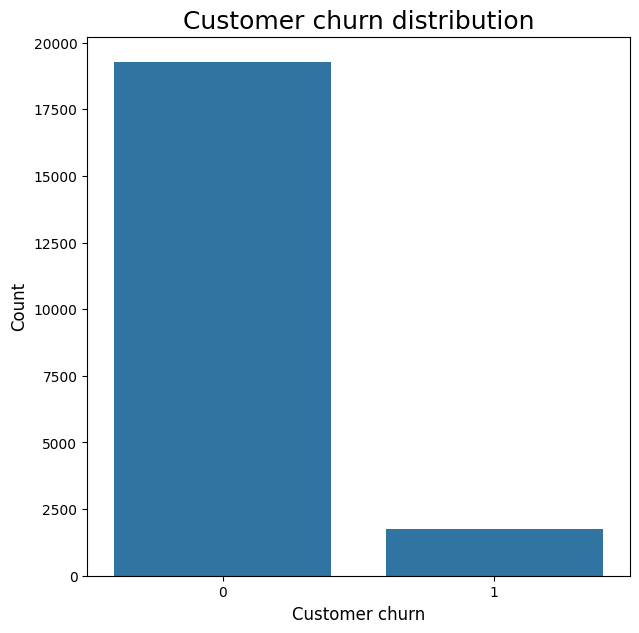

In [44]:
# Visualize churn distribution
plt.figure(figsize=(7, 7))
sns.countplot(x = high_val_train['churn_probability'])
plt.xlabel('Customer churn', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Customer churn distribution', fontsize=18)
plt.show()

#### From the above graph, it can be seem that around 91% of customers are non-churn, while around 8% of customers churn. This indicates a significant class imbalance, which we will address later.

In [45]:
# Create a copy of high_val_train df and use the new df (churn_data) for pruning in the training set
churn_data = high_val_train.copy()
churn_data.reset_index(inplace=True)
churn_data.drop(['index'], axis=1, inplace=True)

In [46]:
churn_data.shape

(20998, 149)

In [47]:
# Get the list of columns with missing values in the training set
mv = round(100*(churn_data.isnull().sum(axis=0)/churn_data.shape[0]), 2)
s = mv.loc[mv>0]
impute_cols_num = list(s.index)
len(impute_cols_num)

81

In [48]:
# Lets try to verify how many values are missing from the dataframe
drop = high_val_train.dropna()
print(churn_data.shape[0] - drop.shape[0])

1061


### Impute missing values using KNN Imputer - Training Set

KNNImputer is a technique used to impute missing values in a dataset based on the values of its nearest neighbors. It works by identifying the k nearest neighbors of each data point with missing values, then averaging or taking a weighted average of the available values from those neighbors to fill in the missing value. This approach leverages the similarity between data points to estimate the missing values more accurately.

In [49]:
# Create imputer instance
imputer = KNNImputer(n_neighbors=5)

In [50]:
# Separate df having columns to be imputed
df_num = churn_data[impute_cols_num]
churn_df = churn_data.drop(impute_cols_num, axis=1)

In [51]:
%%time
# Impute using KNN imputer instance
df_imp = imputer.fit_transform(df_num)

CPU times: total: 30.9 s
Wall time: 30.4 s


In [52]:
# Convert it to df post imputation
df_imp = pd.DataFrame(df_imp, columns=impute_cols_num)
df_imp.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,...,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8
0,21.28,4.83,6.13,56.99,38.11,...,0.0,0.0,0.0,0.00,0.0
1,10.43,24.99,194.43,317.11,341.79,...,0.0,0.0,0.0,0.00,0.0
2,859.53,372.71,0.89,293.46,450.11,...,0.0,0.0,0.0,0.15,0.4
3,93.18,38.29,29.86,531.19,507.76,...,0.0,0.0,0.0,0.00,0.0
4,8.58,11.48,12.68,133.16,158.73,...,0.0,0.0,0.0,0.00,0.0


In [53]:
# Merge the two dataframes together post imputation to create the final training set
final_df = pd.concat([df_imp, churn_df], join='inner', axis=1)
final_df.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,...,jun_vbc_3g,churn_probability,total_amt_6,total_amt_7,total_avg_amt_6_7
0,21.28,4.83,6.13,56.99,38.11,...,0.00,0,1515.0,1473.0,1494.0
1,10.43,24.99,194.43,317.11,341.79,...,0.00,0,808.0,400.0,604.0
2,859.53,372.71,0.89,293.46,450.11,...,0.00,0,1420.0,990.0,1205.0
3,93.18,38.29,29.86,531.19,507.76,...,0.00,0,463.0,519.0,491.0
4,8.58,11.48,12.68,133.16,158.73,...,173.72,0,1385.0,1180.0,1282.5


In [54]:
final_df.shape

(20998, 149)

In [55]:
# Verify no missing value is present in the training set now
final_df.isnull().sum().sort_values(ascending=False)

onnet_mou_6          0
onnet_mou_7          0
onnet_mou_8          0
offnet_mou_6         0
offnet_mou_7         0
                    ..
jun_vbc_3g           0
churn_probability    0
total_amt_6          0
total_amt_7          0
total_avg_amt_6_7    0
Length: 149, dtype: int64

### Impute missing values using the KNN Imputer - Unseen Test Set

In [56]:
# Separate df having columns to be imputed
df_num_unseen = telecom_unseen_df[impute_cols_num]
churn_df_unseen = telecom_unseen_df.drop(impute_cols_num, axis=1)

In [57]:
%%time
# Impute using KNN imputer instance
df_imp_unseen = imputer.transform(df_num_unseen)

CPU times: total: 1min 30s
Wall time: 1min 29s


In [58]:
# Convert it to df post imputation
df_imp_unseen = pd.DataFrame(df_imp_unseen, columns=impute_cols_num)
df_imp_unseen.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,...,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8
0,31.78,20.23,23.11,60.16,32.16,...,0.00,0.00,0.0,0.0,0.00
1,75.51,41.21,19.84,474.34,621.84,...,177.88,94.23,0.0,0.0,0.00
2,7.54,7.86,8.40,16.98,45.81,...,0.00,0.00,0.0,0.0,0.00
3,5.31,2.16,0.00,40.04,205.01,...,1.43,8.65,0.0,0.0,0.00
4,450.93,609.03,700.68,60.94,23.84,...,0.00,0.00,0.0,0.0,0.16


In [59]:
# Merge the two dataframes together post imputation
final_unseen_df = pd.concat([df_imp_unseen, churn_df_unseen], join='inner', axis=1)
final_unseen_df.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,...,jul_vbc_3g,jun_vbc_3g,total_amt_6,total_amt_7,total_avg_amt_6_7
0,31.78,20.23,23.11,60.16,32.16,...,0.00,0.00,103.0,90.0,96.5
1,75.51,41.21,19.84,474.34,621.84,...,0.00,0.00,500.0,500.0,500.0
2,7.54,7.86,8.40,16.98,45.81,...,758.41,241.84,500.0,1000.0,750.0
3,5.31,2.16,0.00,40.04,205.01,...,0.00,0.00,110.0,260.0,185.0
4,450.93,609.03,700.68,60.94,23.84,...,0.00,0.00,356.0,490.0,423.0


In [60]:
final_unseen_df.shape

(30000, 149)

In [61]:
# Verify no missing value is present in the test set now
final_unseen_df.isnull().sum().sort_values(ascending=False)

onnet_mou_6          0
onnet_mou_7          0
onnet_mou_8          0
offnet_mou_6         0
offnet_mou_7         0
                    ..
jul_vbc_3g           0
jun_vbc_3g           0
total_amt_6          0
total_amt_7          0
total_avg_amt_6_7    0
Length: 149, dtype: int64

### Common Utility Methods

In [62]:
def plot_bar_graph(title, month, y_list, data):
    """
    Plot bar graphs for given data.

    Parameters:
    - title (str): Title of the plot.
    - month (list of str): List of month names.
    - y_list (list of str): List of y-variable names corresponding to each month.
    - data (DataFrame): DataFrame containing the data to be plotted.

    Returns:
    - None

    This function plots bar graphs for each month's data based on the provided y-variables.
    It creates subplots for each month, with the corresponding y-variable plotted against 'churn_probability'.
    The title of each subplot includes the specified title along with the month name.
    """
    plt.figure(figsize=(15, 10))
    
    for i, m in enumerate(month):
        plt.subplot(2, 3, i+1)
        plt.title(f'{title} for {m}')
        sns.barplot(x='churn_probability', y=y_list[i], data=data)
    
    plt.tight_layout()
    plt.show()

In [63]:
def outlier_handling(dataframe):
    """
    Applies outlier handling transformations to the values in the given DataFrame.

    Parameters:
    - dataframe (DataFrame): The DataFrame containing the values to be transformed.

    Returns:
    - transformed_values (list): A list containing the transformed values based on the specified conditions.
    """

    transformed_values = []
    for value in dataframe:
        if value <= 0:
            transformed_values.append(float(0))
        elif float(value) == float(1.0):
            transformed_values.append(float(1.5))
        else:
            transformed_values.append(float(np.log1p(value)))

    return transformed_values

In [64]:
def draw_roc(actual, probs):
    fpr, tpr, thresholds = roc_curve(actual, probs,drop_intermediate = False)
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

### Exploratory Data Analysis (EDA)

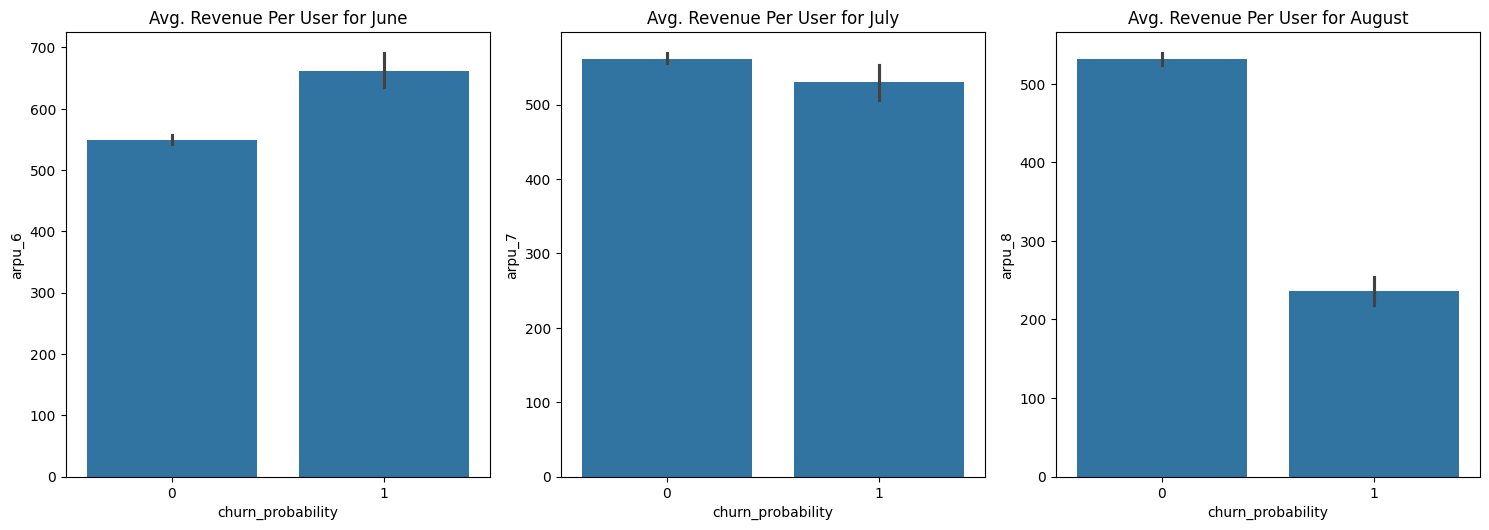

In [65]:
# Visualising Average Revenue per user
arpu_cols = ['arpu_6', 'arpu_7', 'arpu_8']
plot_bar_graph('Avg. Revenue Per User', ['June', 'July', 'August'], arpu_cols, final_df)

#### The drastic decrease in the Average Revenue Per User (ARPU) in month of August (arpu_8) is related to the customers who may churn. In 7th month arpu decrease slightly as compared to 6th for the customers who may churn.

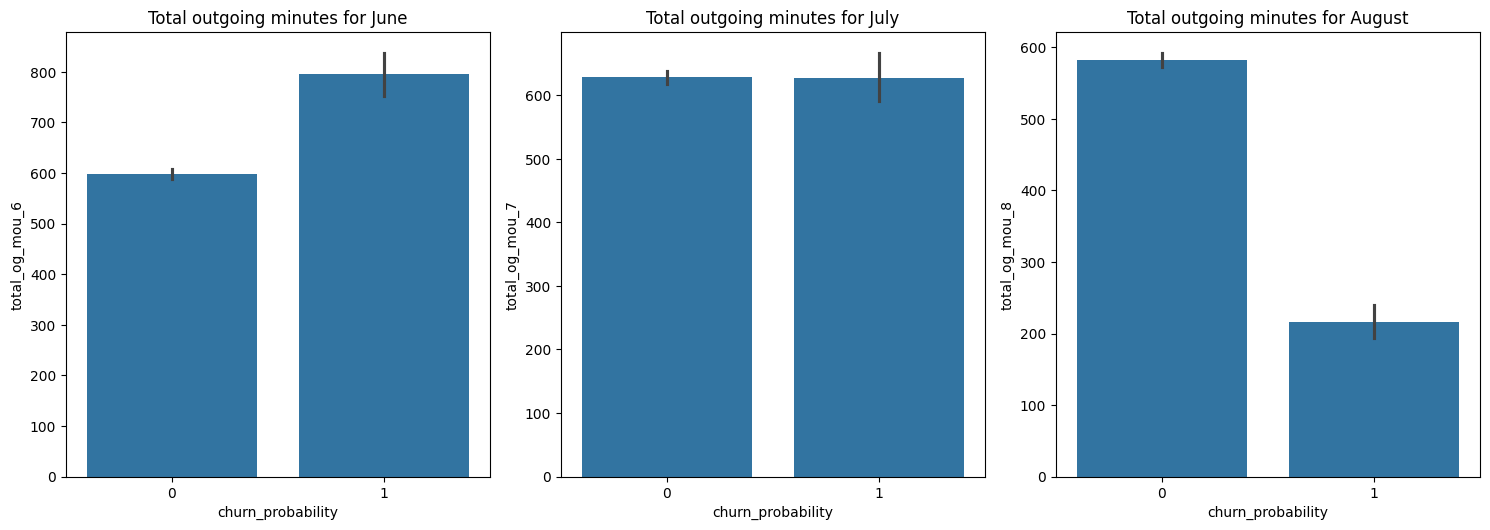

In [66]:
# Visualising Outgoing minutes of usage
total_og_mou_cols = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']
plot_bar_graph('Total outgoing minutes', ['June', 'July', 'August'], total_og_mou_cols, final_df)

#### The customers for whom Total outgoing minutes decreases drastically in the month of August (total_og_mou_8), have high probability to churn.

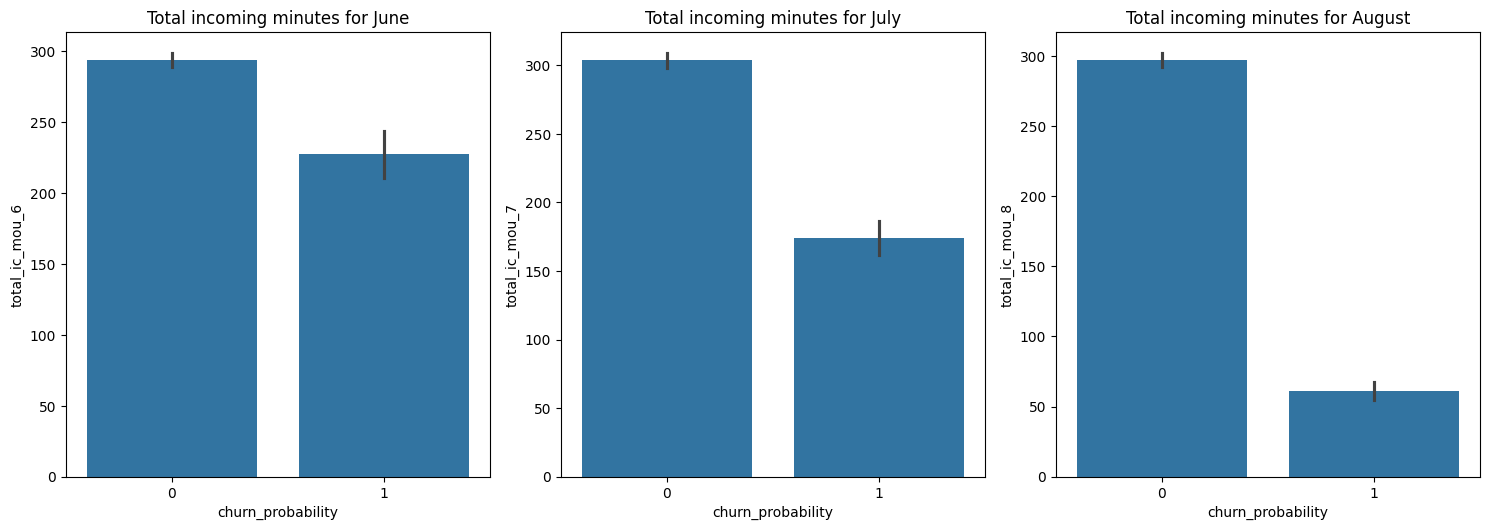

In [67]:
# Visualising incoming minutes of usage
total_ic_mou_cols = ['total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']
plot_bar_graph('Total incoming minutes', ['June', 'July', 'August'], total_ic_mou_cols, final_df)

#### The customers for whom Total incoming minutes decreases drastically in the month of August (total_og_mou_8), have high probability to churn. Though for them decline in Total incoming minutes can be seen for the month of July too.

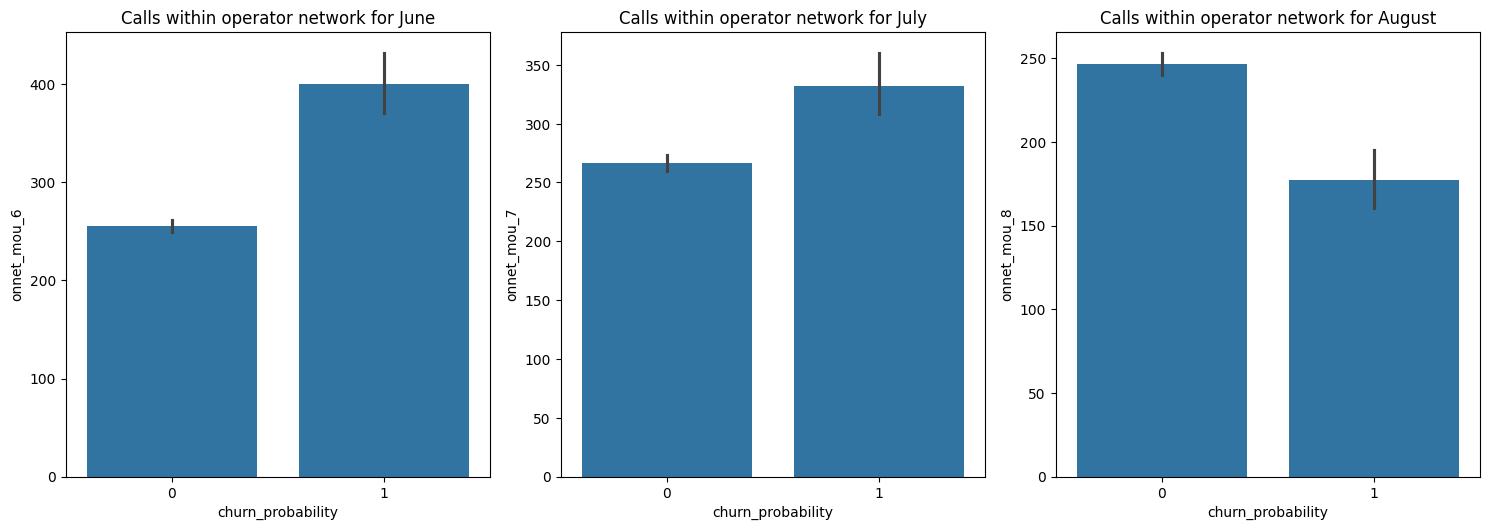

In [68]:
# Visualizing all types of calls within the operator's network.
onnet_mou_cols = ['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']
plot_bar_graph('Calls within operator network', ['June', 'July', 'August'], onnet_mou_cols, final_df)

#### The customers for whom there is a drastic decrease in the Calls within operator network in month of August may churn. They have this decreasing trend in the month of july. too.

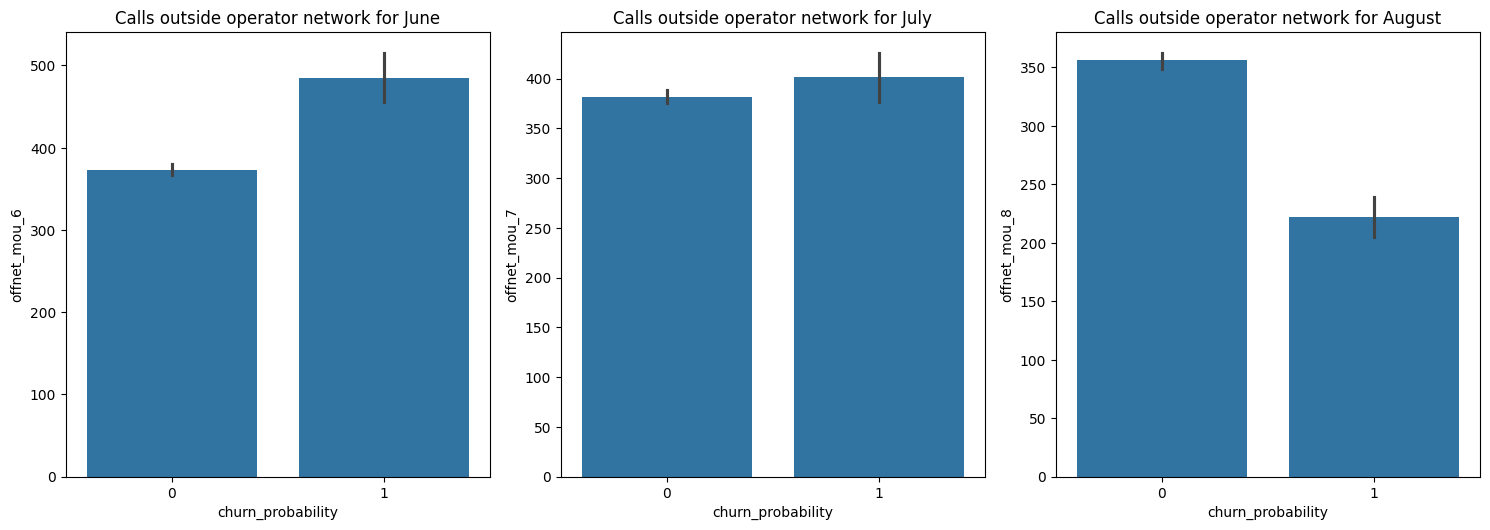

In [69]:
# Visualizing all types of calls made outside the operator network.
offnet_mou_cols = ['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']
plot_bar_graph('Calls outside operator network', ['June', 'July', 'August'], offnet_mou_cols, final_df)

#### The customers for whom there is a drastic decrease in the Calls outside operator network in month of August may churn. They have this decreasing trend in the month of july too.

In [70]:
# Analysing different metrics by extracting them into columns of similar type
amount_data = final_df.loc[:, final_df.columns.str.contains('amt')]
data2g = final_df.loc[:, final_df.columns.str.contains('2g')]
data3g = final_df.loc[:, final_df.columns.str.contains('3g')]
ic_mou_data = final_df.loc[:, final_df.columns.str.contains('ic') & final_df.columns.str.contains('mou')]
net_mou_data = final_df.loc[:, final_df.columns.str.contains('net_mou')]
og_mou_data = final_df.loc[:, final_df.columns.str.contains('og') & final_df.columns.str.contains('mou')]
rech_data = final_df.loc[:, final_df.columns.str.contains('rech')]
total_data = final_df.loc[:, final_df.columns.str.contains('tot')]

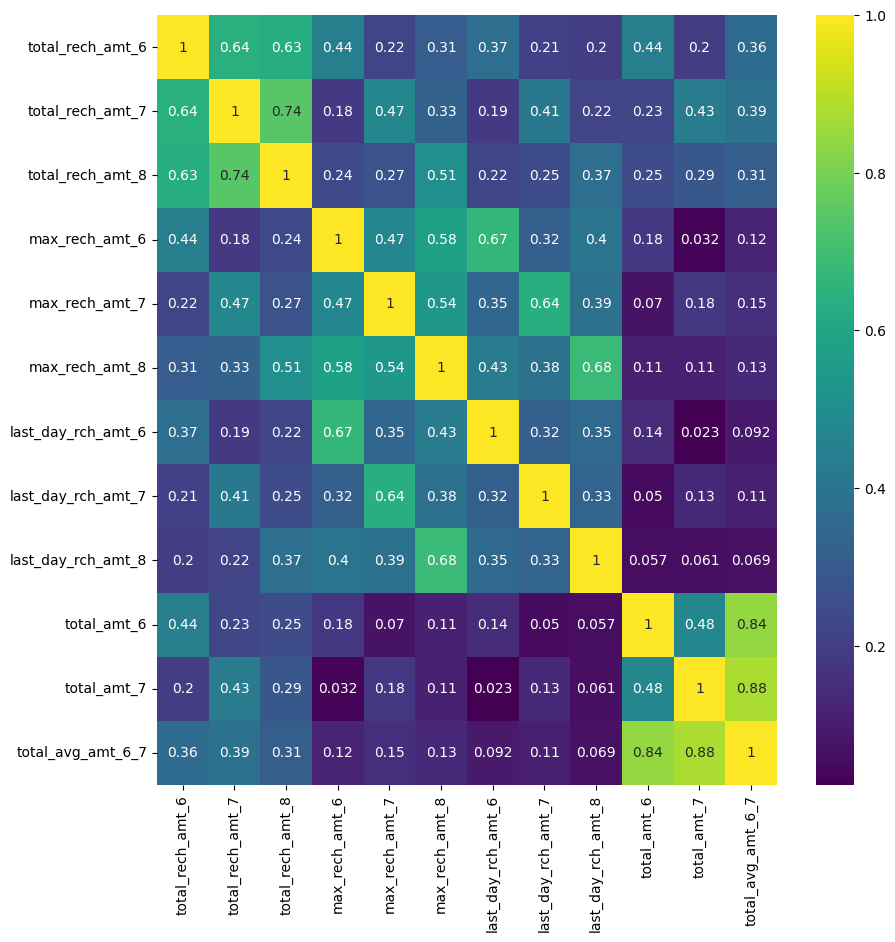

In [71]:
# Amount data
plt.figure(figsize=(10,10))
sns.heatmap(amount_data.corr(), annot=True, cmap='viridis')
plt.show()

Observations:

Correlation of 74% exists between the total recharge amount in month 7 (total rech amt 7) and month 8 (total rech amt 8).
Correlation of 68% is observed between the maximum recharge amount in month 8 (max rech amt 8) and the last day's recharge amount (last_day_rch_amt_8) in the same month.
The customers who are unlikely to churn tend to recharge higher amounts in month 8.

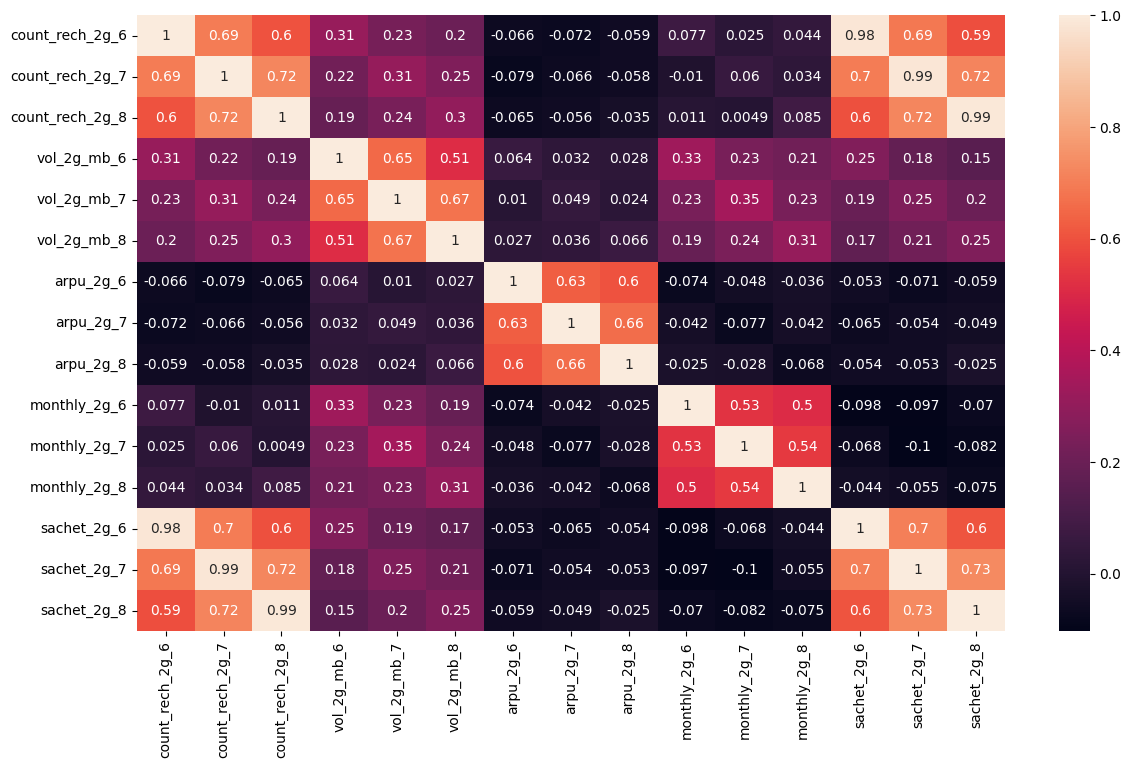

In [72]:
# data2g
plt.figure(figsize=(14,8))
sns.heatmap(data2g.corr(), annot=True)
plt.show()

Observations:

There is a strong correlation between recharge quantities in months 7 and 8.

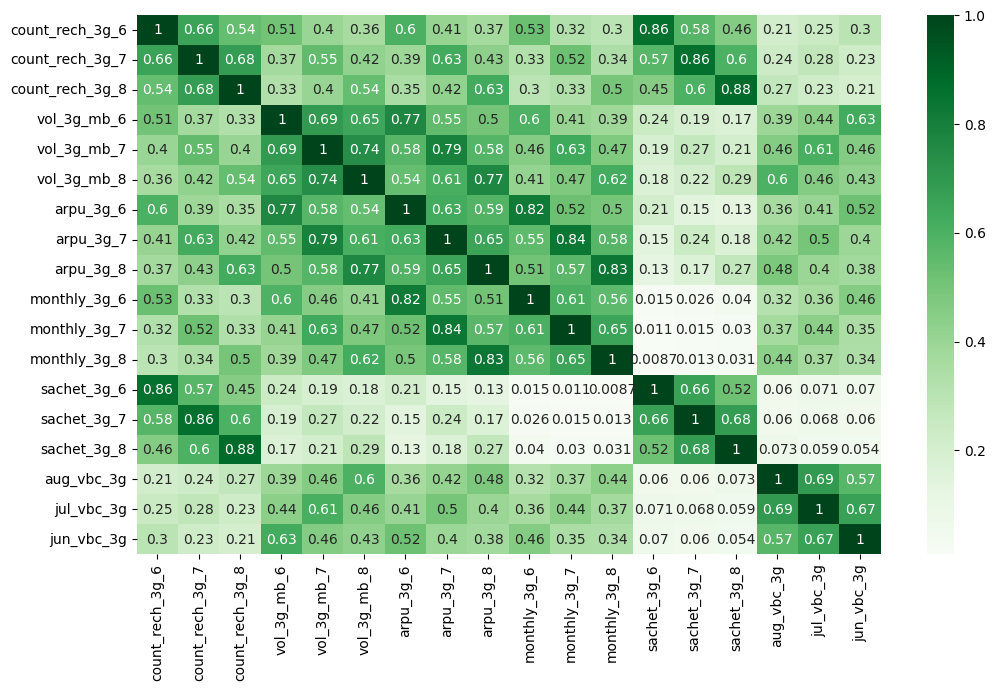

In [73]:
#data3g
plt.figure(figsize=(12,7))
sns.heatmap(data3g.corr(),annot=True, cmap='Greens')
plt.show()

There is a strong correlation between recharge quantities in months 7 and 8.

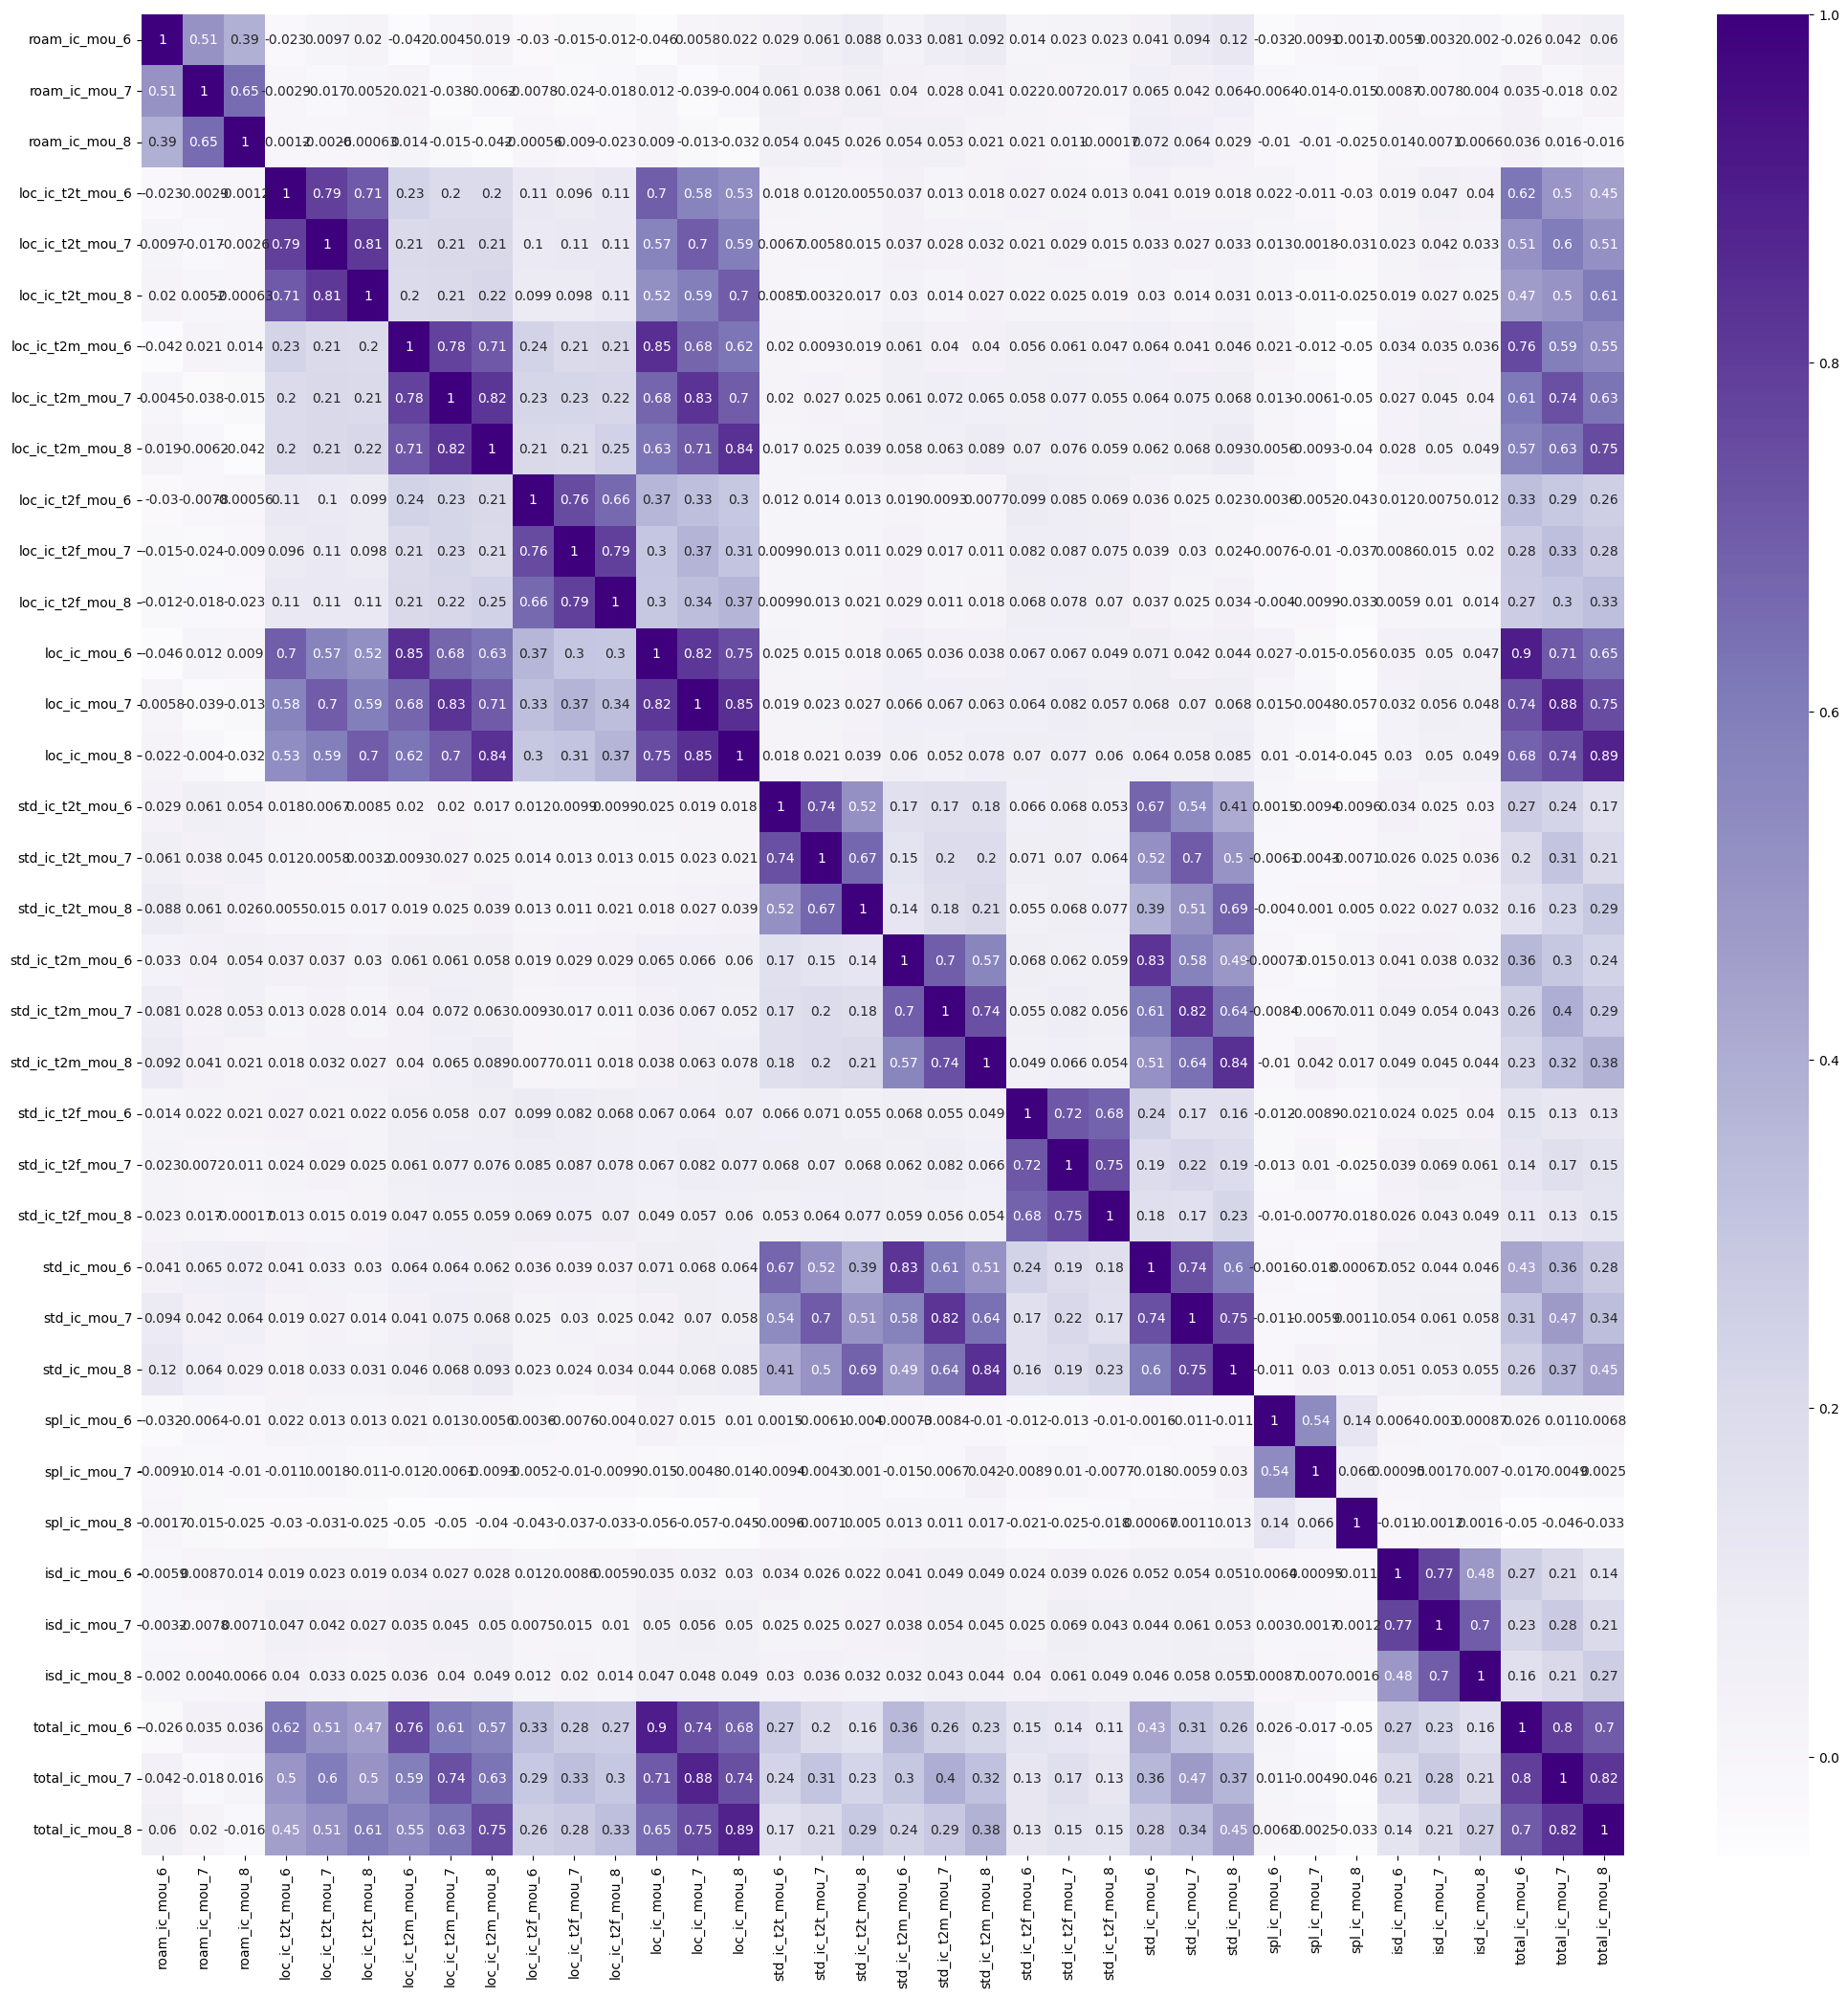

In [74]:
#ic_mou_data
plt.figure(figsize=(25, 25))
sns.heatmap(ic_mou_data.corr(), annot=True, cmap='Purples')
plt.show()

##### The following variables or features have high correlation:
##### total_ic_mou_6 and loc_ic_mou_6, 
##### total_ic_mou_7 and loc_ic_mou_7, 
##### total_ic_mou_8 and loc_ic_mou_8, 
##### std_ic_mou_6 and std_ic_t2f_mou_6, 
##### std_ic_mou_7 and std_ic_t2f_mou_7, 
##### std_ic_mou_8 and std_ic_t2f_mou_8

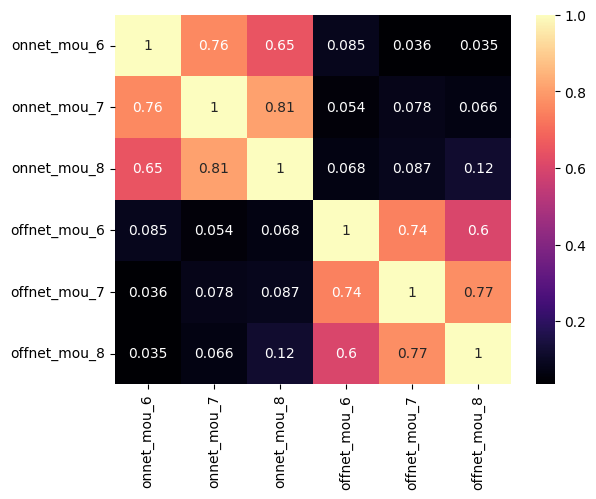

In [75]:
#net_mou_data
sns.heatmap(net_mou_data.corr(), annot=True, cmap='magma')
plt.show()

##### No correlation between the usage minutes for on-net and off-net calls.
##### A strong correlation is there between the on-net usage minutes in months 7 and 8.
##### A strong correlation is there between the off-net usage minutes in months 7 and 8.

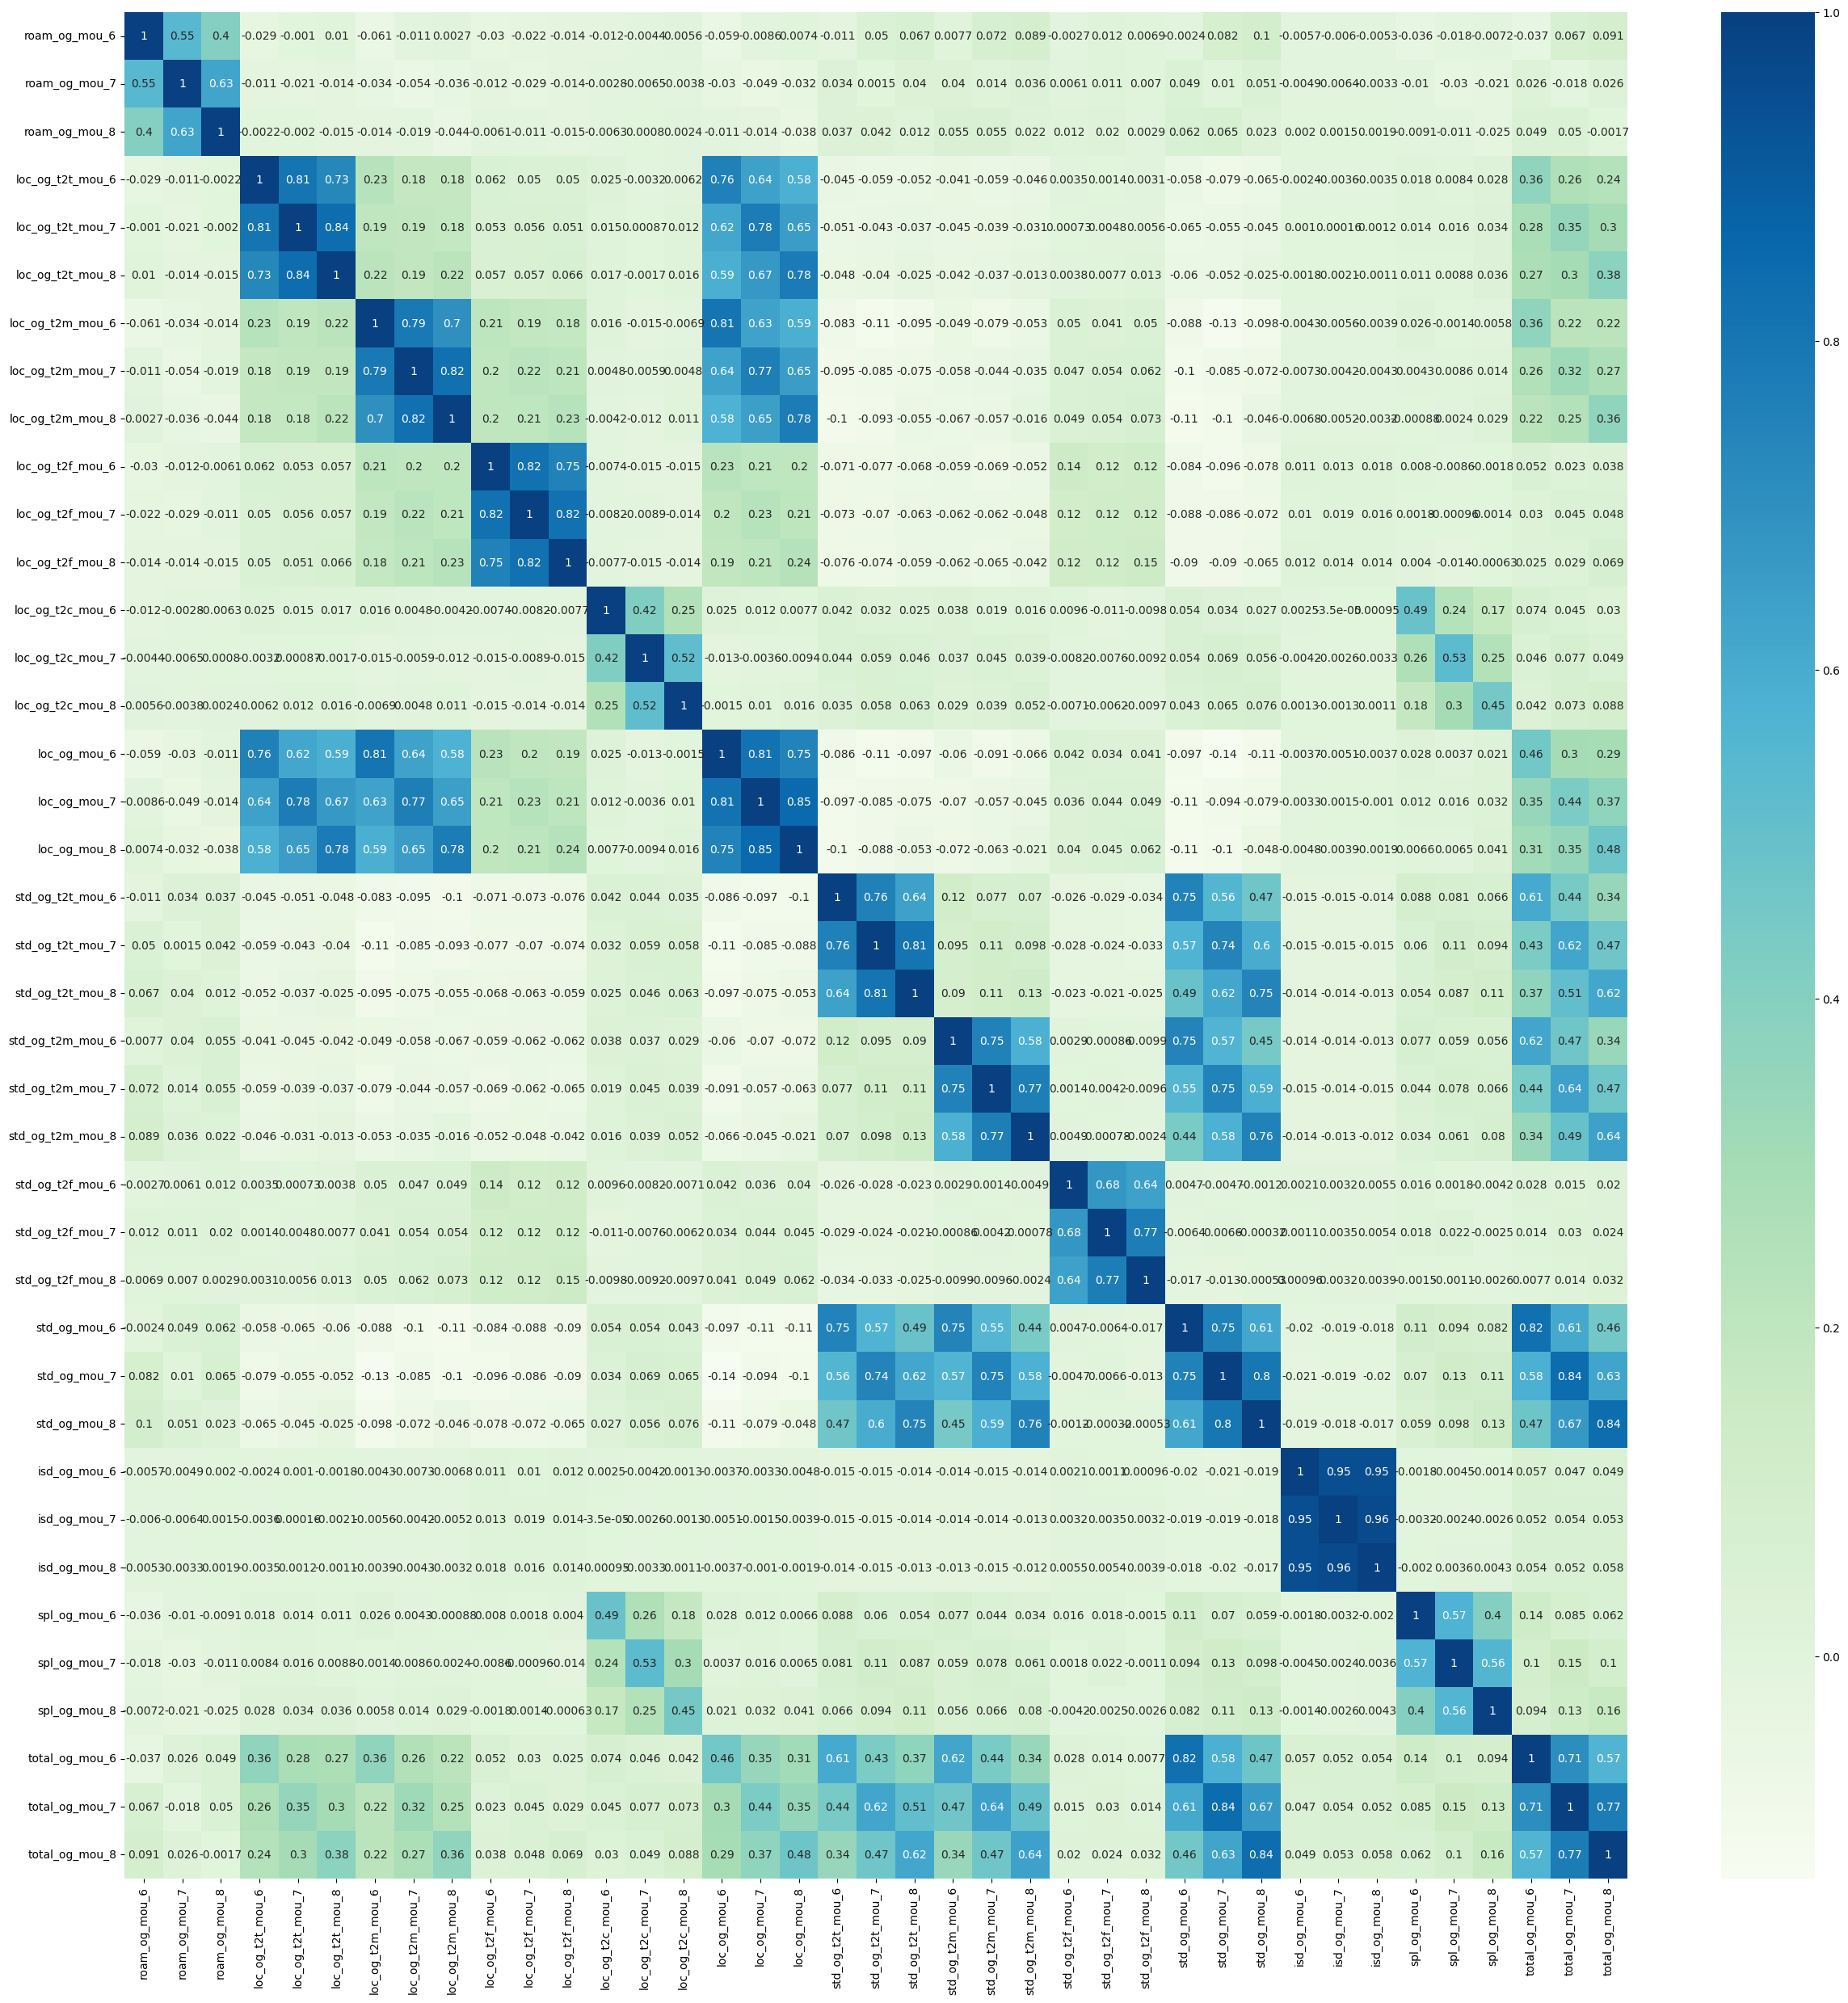

In [76]:
#og_mou_data
plt.figure(figsize=(30,30))
sns.heatmap(og_mou_data.corr(), annot=True, cmap='GnBu')
plt.show()

##### There is strong correlation between the following variables:
##### isd_og_mou_7 and isd_og_mou_6
##### isd_og_mou_8 and isd_og_mou_6
##### isd_og_mou_8 and isd_og_mou_7
##### total_og_mou_6 and std_og_mou_6
##### total_og_mou_7 and std_og_mou_7
##### total_og_mou_8 and std_og_mou_8

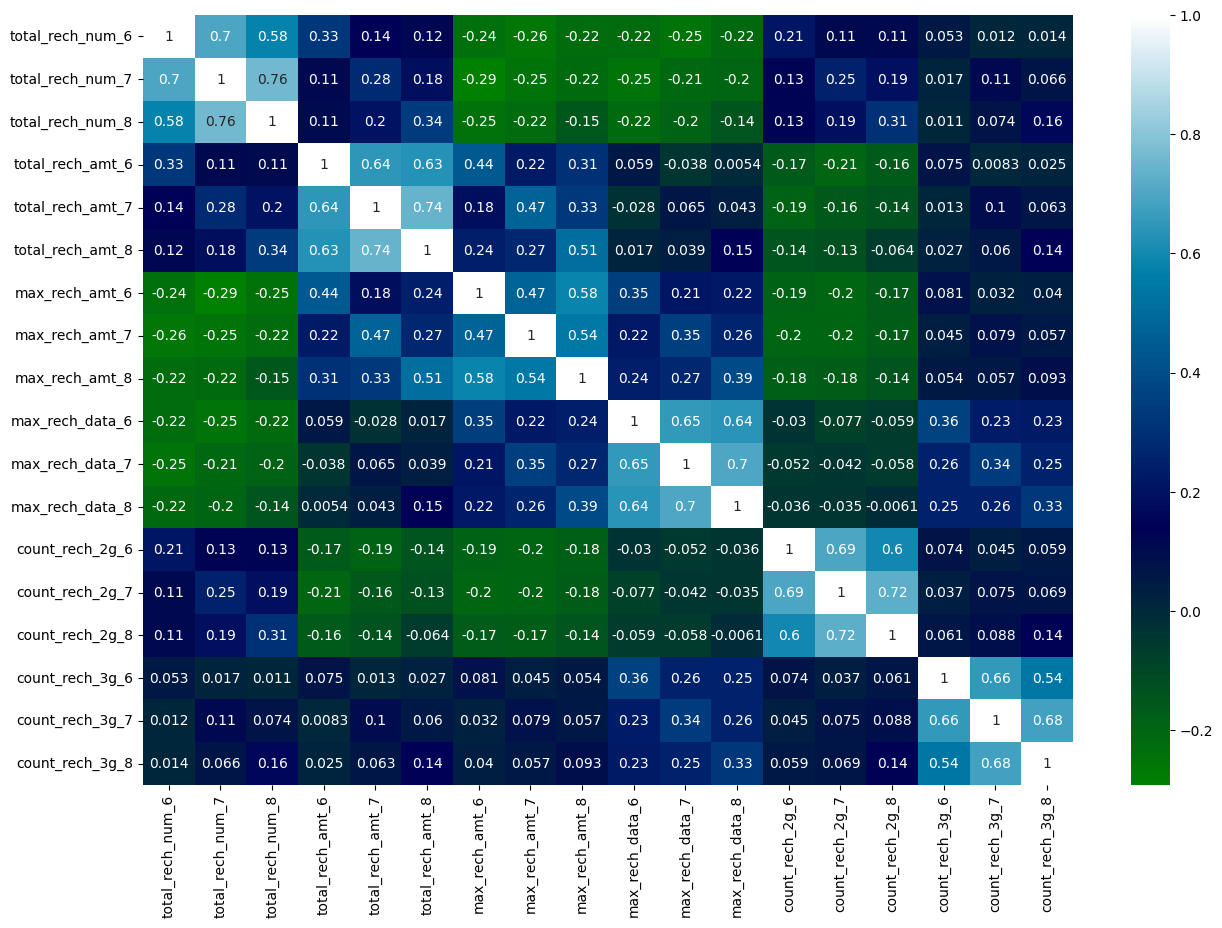

In [77]:
#rech_data
plt.figure(figsize=(15,10))
sns.heatmap(rech_data.corr(), annot=True, cmap='ocean')
plt.show()

There is significant correlation between the average recharge amount and the recharge amount for both months 6 and 7.
A strong correlation of 76% exists between the total recharge for month 7 and the recharge for month 8.
Variables correlated with month 8 is highly likely correlated with churn prediction.

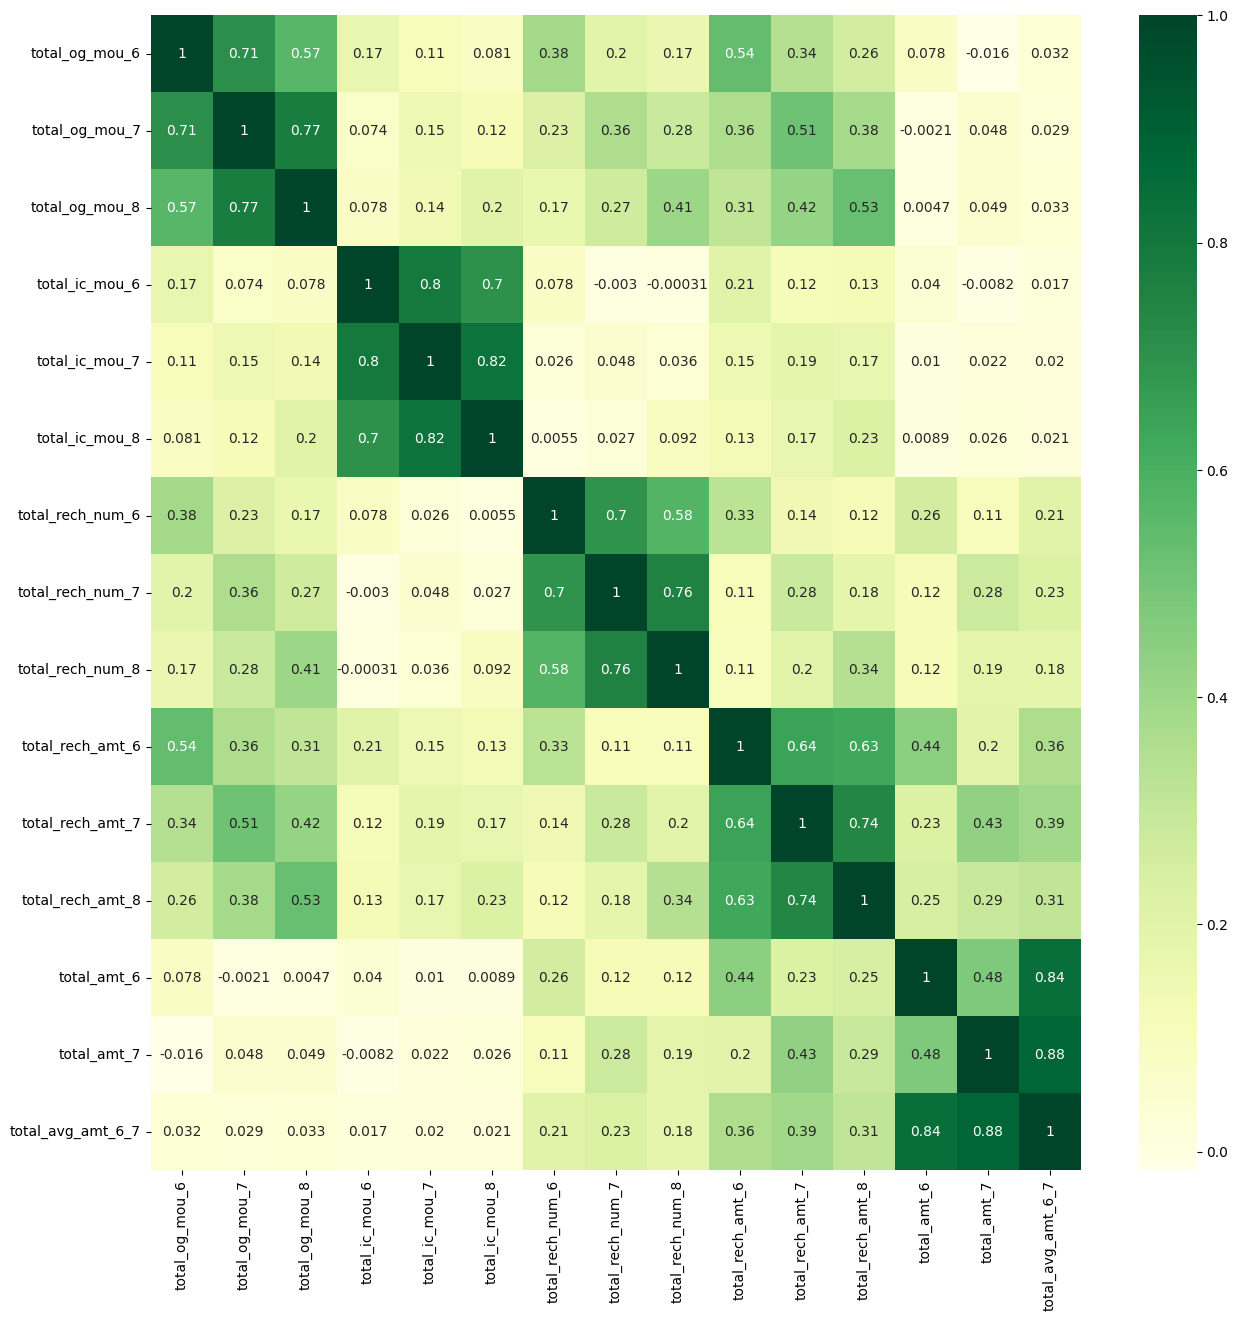

In [78]:
#total_data
plt.figure(figsize=(15,15))
sns.heatmap(total_data.corr(), annot=True, cmap='YlGn')
plt.show()

##### There strong correlation between the incoming (82%) and outgoing minutes (77%) of usage in months 7 and 8.
##### High usage suggests that customers are less likely to churn.

In [79]:
# Inspecting shape of the training dataset
final_df.shape

(20998, 149)

In [80]:
final_df.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,...,jun_vbc_3g,churn_probability,total_amt_6,total_amt_7,total_avg_amt_6_7
0,21.28,4.83,6.13,56.99,38.11,...,0.00,0,1515.0,1473.0,1494.0
1,10.43,24.99,194.43,317.11,341.79,...,0.00,0,808.0,400.0,604.0
2,859.53,372.71,0.89,293.46,450.11,...,0.00,0,1420.0,990.0,1205.0
3,93.18,38.29,29.86,531.19,507.76,...,0.00,0,463.0,519.0,491.0
4,8.58,11.48,12.68,133.16,158.73,...,173.72,0,1385.0,1180.0,1282.5


In [81]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20998 entries, 0 to 20997
Columns: 149 entries, onnet_mou_6 to total_avg_amt_6_7
dtypes: category(7), float64(117), int64(25)
memory usage: 22.9 MB


In [82]:
# Inspecting the shape of the test set
final_unseen_df.shape

(30000, 149)

In [83]:
final_unseen_df.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,...,jul_vbc_3g,jun_vbc_3g,total_amt_6,total_amt_7,total_avg_amt_6_7
0,31.78,20.23,23.11,60.16,32.16,...,0.00,0.00,103.0,90.0,96.5
1,75.51,41.21,19.84,474.34,621.84,...,0.00,0.00,500.0,500.0,500.0
2,7.54,7.86,8.40,16.98,45.81,...,758.41,241.84,500.0,1000.0,750.0
3,5.31,2.16,0.00,40.04,205.01,...,0.00,0.00,110.0,260.0,185.0
4,450.93,609.03,700.68,60.94,23.84,...,0.00,0.00,356.0,490.0,423.0


In [84]:
final_unseen_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 149 entries, onnet_mou_6 to total_avg_amt_6_7
dtypes: category(6), float64(117), int64(26)
memory usage: 32.9 MB


## Dummy Variable Creation (One Hot Encoding) - Training Set

In [85]:
# Creating dummies for categorical columns
dummy_df = pd.get_dummies(final_df[['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6']], drop_first=True, dtype='int')

In [86]:
final_df = pd.concat([final_df, dummy_df], axis=1)

In [87]:
# drop the category cols
final_df.drop(['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6'], axis=1, inplace=True)


In [88]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20998 entries, 0 to 20997
Columns: 155 entries, onnet_mou_6 to night_pck_user_6_1.0
dtypes: category(1), float64(117), int64(37)
memory usage: 24.7 MB


In [89]:
final_df.shape

(20998, 155)

### Dummy Variable Creation (One Hot Encoding) - Test Set

In [90]:
# Creating dummies for categorical columns
dummy_unseen_df = pd.get_dummies(final_unseen_df[['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6']], drop_first=True, dtype='int')


In [91]:
final_unseen_df = pd.concat([final_unseen_df, dummy_unseen_df], axis=1)

In [92]:
# drop the category cols
final_unseen_df.drop(['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6'], axis=1, inplace=True)

In [93]:
final_unseen_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 155 entries, onnet_mou_6 to night_pck_user_6_1.0
dtypes: float64(117), int64(38)
memory usage: 35.5 MB


In [94]:
final_unseen_df.shape

(30000, 155)

## Outlier Treatment

In [95]:
# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%
final_df.describe(percentiles=[.25, .50, .75, .90, .95, .99])

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,...,fb_user_6_1.0,night_pck_user_7_0.0,night_pck_user_7_1.0,night_pck_user_6_0.0,night_pck_user_6_1.0
count,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,...,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000
mean,267.170793,272.101052,240.685694,382.262764,383.248007,...,0.516811,0.554339,0.013049,0.543290,0.013192
std,466.085572,486.515122,465.230750,480.518888,490.939535,...,0.499729,0.497050,0.113487,0.498134,0.114098
min,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.440000,17.940000,13.815000,79.540000,75.790000,...,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
75%,292.127500,290.620000,245.405000,495.255000,498.790000,...,1.000000,1.000000,0.000000,1.000000,0.000000
90%,766.325000,788.211000,672.592000,912.390000,922.828000,...,1.000000,1.000000,0.000000,1.000000,0.000000
95%,1147.427500,1194.174500,1086.979500,1265.446000,1274.301500,...,1.000000,1.000000,0.000000,1.000000,0.000000
99%,2164.456000,2239.353000,2153.499100,2338.036700,2394.084300,...,1.000000,1.000000,1.000000,1.000000,1.000000


In [96]:
numerical_cols = list(final_df.select_dtypes(exclude='category'))
numerical_cols

['onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2m_mou

outlier_handling method treats outliers and adjusts skewness in the dataset to improve data robustness and analysis accuracy.

In [97]:
# Handle outliers of numerical columns in the training set
final_df[numerical_cols] = final_df[numerical_cols].apply(outlier_handling)

In [98]:
# Inspecting the numerical columns again in the training set
final_df.describe(percentiles=[.25, .50, .75, .90, .95, .99])

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,...,fb_user_6_1.0,night_pck_user_7_0.0,night_pck_user_7_1.0,night_pck_user_6_0.0,night_pck_user_6_1.0
count,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,...,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000
mean,4.211139,4.187527,3.998177,5.094078,5.069483,...,0.775217,0.831508,0.019573,0.814935,0.019788
std,2.016294,2.044530,2.066726,1.674873,1.700992,...,0.749594,0.745576,0.170230,0.747201,0.171147
min,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.017494,2.941276,2.695640,4.388754,4.341074,...,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
75%,5.680608,5.675452,5.506977,6.207090,6.214188,...,1.500000,1.500000,0.000000,1.500000,0.000000
90%,6.642910,6.671034,6.512625,6.817163,6.828526,...,1.500000,1.500000,0.000000,1.500000,0.000000
95%,7.046149,7.086047,6.992078,7.143970,7.150938,...,1.500000,1.500000,0.000000,1.500000,0.000000
99%,7.680386,7.714389,7.675314,7.757494,7.781174,...,1.500000,1.500000,1.500000,1.500000,1.500000


In [99]:
# Handle outliers of numerical columns in the test set
final_unseen_df[numerical_cols] = final_unseen_df[numerical_cols].apply(outlier_handling)

In [100]:
# Inspecting the numerical columns again in the test set
final_unseen_df.describe(percentiles=[.25, .50, .75, .90, .95, .99])

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,...,fb_user_6_1.0,night_pck_user_7_0.0,night_pck_user_7_1.0,night_pck_user_6_0.0,night_pck_user_6_1.0
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,3.455662,3.399474,3.378267,4.370298,4.322030,...,0.345100,0.377350,0.007950,0.369900,0.009350
std,1.920246,1.947314,1.946923,1.640813,1.665584,...,0.631323,0.650881,0.108914,0.646559,0.118059
min,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.163093,2.059239,2.033070,3.599775,3.514824,...,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
75%,4.848802,4.825109,4.816605,5.502207,5.462984,...,0.000000,1.500000,0.000000,0.000000,0.000000
90%,5.875610,5.865638,5.844396,6.167812,6.173644,...,1.500000,1.500000,0.000000,1.500000,0.000000
95%,6.432364,6.435466,6.414786,6.575421,6.609280,...,1.500000,1.500000,0.000000,1.500000,0.000000
99%,7.232457,7.293730,7.295839,7.326309,7.341630,...,1.500000,1.500000,0.000000,1.500000,0.000000


In [101]:
final_df.shape

(20998, 155)

## Model Building and Evaluation

#### Train-Test Split
##### Given the availability of the separate test.csv file for testing purposes, this train-test split will exclusively operate on the train.csv dataset. It involves allocating 80% of the data for training and 20% for validation.

In [102]:
# Partitioning the dataset into the feature variable 'X' and the response variable 'y'.
X = final_df.drop(['churn_probability'], axis=1)
y = final_df['churn_probability']

In [103]:
X.shape

(20998, 154)

In [104]:
y.shape

(20998,)

In [105]:
X.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,...,fb_user_6_1.0,night_pck_user_7_0.0,night_pck_user_7_1.0,night_pck_user_6_0.0,night_pck_user_6_1.0
0,3.103689,1.763017,1.964311,4.060271,3.666378,...,1.5,1.5,0.0,1.5,0.0
1,2.436241,3.257712,5.275202,5.762397,5.837118,...,1.5,0.0,0.0,1.5,0.0
2,6.757548,5.923480,0.636577,5.685143,6.111711,...,0.0,0.0,0.0,0.0,0.0
3,4.545208,3.670970,3.429461,6.277001,6.231976,...,0.0,1.5,0.0,1.5,0.0
4,2.259678,2.524127,2.615935,4.899033,5.073485,...,1.5,1.5,0.0,1.5,0.0


In [106]:
# Train test split - 80% training data, 20% validation data
X_train,X_eval,Y_train,Y_eval = train_test_split(X, y, test_size=0.20, random_state=100)

In [107]:
# Checking the shape after split
print('X_train Shape:', X_train.shape)
print('Y_train Shape:', Y_train.shape)
print('X_eval Shape:', X_eval.shape)
print('Y_eval Shape:', Y_eval.shape)

X_train Shape: (16798, 154)
Y_train Shape: (16798,)
X_eval Shape: (4200, 154)
Y_eval Shape: (4200,)


### Model Building 

- Logistic Regression
- SVM Classifier
- Decision Tree
- Random Forest
- XGBoost

In [108]:
def create_pipeline(model, param_grid, n_features=25, apply_pca=None):
    """
    Creates a pipeline with SMOTE, RFE, PCA (optional), and a given model.

    Parameters:
    - model: The machine learning model (e.g., RandomForestClassifier()).
    - param_grid: Hyperparameter grid for GridSearchCV.
    - n_features: Number of features for RFE (default: 25).
    - apply_pca: Whether to apply PCA ('Yes' or None).

    Returns:
    - A pipeline wrapped with GridSearchCV.
    """
    
    # Define steps in pipeline
    
    if apply_pca == None:
        steps = [
        ("oversampling", SMOTE(random_state=42)),  # Handle class imbalance
        ("rfe", RFE(estimator=model, n_features_to_select=n_features)),  # Feature selection
        ("model", model)
    ]
    else:
        steps = [
        ("pca", PCA(n_components=n_features, random_state=42)),
        ("oversampling", SMOTE(random_state=42)),  # Handle class imbalance
        ("model", model)
         ]

    # Create pipeline
    pipeline = Pipeline(steps)
    
    # Use GridSearchCV for hyperparameter tuning
    from joblib import parallel_backend
    with parallel_backend('threading'):
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    
    return grid_search

In [109]:
def calculate_classification_metrics(y_true, y_pred):
    """
    Calculate various classification metrics.

    Parameters:
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.

    Returns:
    pd.DataFrame: A DataFrame containing the calculated metrics.
    """
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix')
    print()
    print(cm)
    
    # True Positives, False Positives, True Negatives, False Negatives
    TP=np.sum((y_pred==1) & (y_true==1))
    TN=np.sum((y_pred==0) & (y_true==0))
    FP=np.sum((y_pred==1) & (y_true==0))
    FN=np.sum((y_pred==0) & (y_true==1))

    # Accuracy Score
    accuracy = round((TP + TN) / (TP + FP + TN + FN), 4)

    # Sensitivity (Recall or True Positive Rate)
    recall = round(TP / (TP + FN), 4)

    # Specificity
    specificity = round(TN / (TN + FP), 4)

    # Precision
    precision = round(TP / (TP + FP), 4)

    # False Positive Rate
    false_positive_rate = round(FP / (FP + TN), 4)

    # True Positive Rate
    true_positive_rate = recall
    
    # F1-score
    f1_score=2*(recall*precision)/(recall+precision)

    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Recall', 'Specificity', 'Precision', 'False Positive Rate', 'True Positive Rate','F1_score'],
        'Value': [accuracy, recall, specificity, precision, false_positive_rate, true_positive_rate,f1_score]
    })

    return metrics_df

In [110]:
models = {
    "Logistic Regression": (
        LogisticRegression(),
        {"model__C": [0.01, 0.1, 1, 10], "model__solver": ["lbfgs", "liblinear"]}
    ),
    
    "Decision Tree": (
        DecisionTreeClassifier(),
        {"model__max_depth": [3, 5, 10, None], "model__min_samples_split": [2, 5, 10]}
    ),

    "Random Forest": (
        RandomForestClassifier(),
        {"model__n_estimators": [50, 100, 200], "model__max_depth": [3, 5, 10, None]}
    ),

    "Gradient Boosting": (
        GradientBoostingClassifier(),
        {"model__n_estimators": [50, 100, 200], "model__learning_rate": [0.01, 0.1, 0.2]}
    ),

    "Support Vector Machine": (
        SVC(probability=True),
        {"model__C": [0.1, 1, 10], "model__kernel": ["linear"]}
    ),

    "XGBoost": (
        XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
        {"model__n_estimators": [50, 100, 200], "model__learning_rate": [0.01, 0.1, 0.2]}
    )

}

In [113]:
%%time
models = {
    "LogisticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "SVC": SVC(probability=True)  # Needed for PR curves & probability-based tasks
}

param_grid = {
    "LogisticRegression": {"model__C": [0.1, 1, 10]},
    "RandomForest": {"model__n_estimators": [50, 100]},
    "SVC": {"model__C": [0.1, 1], "model__kernel": ["linear", "rbf"]}
}

# Create pipelines for each model
pipelines = {}

for model_name, model in models.items():
    pipeline = Pipeline([
        ("smote", SMOTE(random_state=42)),  # Resampling
        ("rfe", RFE(estimator=LogisticRegression(), n_features_to_select=60)),  # Feature Selection
        ("pca", PCA(n_components=20, random_state=42)),  # Dimensionality Reduction
        ("model", model)  # Final Model
    ])
    
    # Add to dictionary
    pipelines[model_name] = GridSearchCV(pipeline, param_grid[model_name], cv=5, n_jobs=-1)

# Train models
for name, clf in pipelines.items():
    print(f"Training {name}...")
    clf.fit(X_train, Y_train)  # Fit pipeline

    Y_eval_pred=clf.predict(X_eval)
    Y_train_pred=clf.predict(X_train)



    print(f"Best parameters for {name}: {clf.best_params_}")
    print(f"Train Accuracy\n: {calculate_classification_metrics(Y_train,Y_train_pred)}")
    print(f"Test Accuracy\n: {calculate_classification_metrics(Y_eval, Y_eval_pred)}")
    print("-" * 50)

Training LogisticRegression...
Best parameters for LogisticRegression: {'model__C': 10}
Confusion Matrix

[[13509  1891]
 [  289  1109]]
Train Accuracy
:                 Metric     Value
0             Accuracy  0.870200
1               Recall  0.793300
2          Specificity  0.877200
3            Precision  0.369700
4  False Positive Rate  0.122800
5   True Positive Rate  0.793300
6             F1_score  0.504356
Confusion Matrix

[[3405  458]
 [  71  266]]
Test Accuracy
:                 Metric     Value
0             Accuracy  0.874000
1               Recall  0.789300
2          Specificity  0.881400
3            Precision  0.367400
4  False Positive Rate  0.118600
5   True Positive Rate  0.789300
6             F1_score  0.501407
--------------------------------------------------
Training RandomForest...
Best parameters for RandomForest: {'model__n_estimators': 50}
Confusion Matrix

[[15396     4]
 [    0  1398]]
Train Accuracy
:                 Metric     Value
0             Accura

In [ ]:
# %%time

# store_model_mets=pd.DataFrame()
# store_best_estimator = pd.DataFrame()

# for model_name, (model, param_grid) in models.items():
#     print(f"\n🔹 Training {model_name}...")
    
#     pipeline = create_pipeline(model, param_grid,n_features=25,apply_pca=None)
#     pipeline.fit(X_train, Y_train)
    
#     best_pipeline = pipeline.best_estimator_
    
    
#     # Get SMOTE step and apply it to X_train_pca
#     smote_step = best_pipeline.named_steps["oversampling"]  # Adjust step name if needed
#     X_train_resampled, Y_train_resampled = smote_step.fit_resample(X_train, Y_train)
    
#     # Get RFE step and apply it to X_train
#     rfe_step = best_pipeline.named_steps["rfe"]  # Adjust step name if needed
#     X_train_rfe= rfe_step.transform(X_train_resampled)


#     # Now train the model on resampled data
#     model = best_pipeline.named_steps["model"]
#     # model.fit(X_train_rfe, Y_train_resampled)

#     # Predict on train and test data
#     Y_pred_train = model.predict(X_train_rfe)
#     # Y_pred_train = pipeline.predict(X_train[:200:])

        
#     Y_pred = pipeline.predict(X_eval)

    
#     # Evaluate performance
#     print(f"Best Params for {model_name}: {pipeline.best_params_}")
#     print(f"Best model for {model_name}: {pipeline.best_estimator_}")
#     model_params=pd.DataFrame({'best_params':pipeline.best_params_,'best_model':pipeline.best_estimator_}).assign(model_name=model_name)
#     store_best_estimator=pd.concat([model_params,store_best_estimator])
    
    
#     print("\nClassification Report-train:")
#     print(calculate_classification_metrics(Y_train_resampled, Y_pred_train))
#     print("\nClassification Report-test:")
#     print(calculate_classification_metrics(Y_eval, Y_pred))
    
#     train_met=calculate_classification_metrics(Y_train_resampled, Y_pred_train).assign(model_name=model_name,data='train')
#     eval_met=calculate_classification_metrics(Y_eval, Y_pred).assign(model_name=model_name,data='evaluation')
#     store_model_mets=pd.concat([store_model_mets,train_met,eval_met])
# display(store_best_estimator)
# display(store_model_mets)


🔹 Training Logistic Regression...


In [ ]:
# %%time
# pca_store_model_mets=pd.DataFrame()
# pca_store_best_estimator = pd.DataFrame()

# for model_name, (model, param_grid) in models.items():
#     print(f"\n🔹 Training {model_name}...")
    
#     pipeline = create_pipeline(model, param_grid,n_features=25,apply_pca="yes")
#     pipeline.fit(X_train, Y_train)
    
#     best_pipeline = pipeline.best_estimator_
    
#     # Get PCA step and apply it to X_train
#     pca_step = best_pipeline.named_steps["pca"]  # Adjust step name if needed
#     X_train_pca= pca_step.transform(X_train)

#     # Get SMOTE step and apply it to X_train_pca
#     smote_step = best_pipeline.named_steps["oversampling"]  # Adjust step name if needed
#     X_train_resampled, Y_train_resampled = smote_step.fit_resample(X_train_pca, Y_train)

#     # Now train the model on resampled data
#     model = best_pipeline.named_steps["model"]
#     model.fit(X_train_resampled, Y_train_resampled)

#     # Predict on train and test data
#     Y_pred_train = model.predict(X_train_resampled)
    
    
#     Y_pred = pipeline.predict(X_eval)

    
#     # Evaluate performance
#     print(f"Best Params for {model_name}: {pipeline.best_params_}")
#     print(f"Best model for {model_name}: {pipeline.best_estimator_}")
#     model_params=pd.DataFrame({'best_params':pipeline.best_params_,'best_model':pipeline.best_estimator_}).assign(model_name=model_name)
#     pca_store_best_estimator=pd.concat([model_params,pca_store_best_estimator])
    
#     # print(f"Accuracy: {accuracy_score(Y_eval, Y_pred):.2f}")
#     print("\nClassification Report-test:")
#     print(calculate_classification_metrics(Y_eval, Y_pred))
    
#     print("\nClassification Report-train:")
#     print(calculate_classification_metrics(Y_train_resampled, Y_pred_train))
    
#     train_met=calculate_classification_metrics(Y_train_resampled, Y_pred_train).assign(model_name=model_name,data='train')
#     eval_met=calculate_classification_metrics(Y_eval, Y_pred).assign(model_name=model_name,data='evaluation')
#     pca_store_model_mets=pd.concat([pca_store_model_mets,train_met,eval_met])
# display(pca_store_model_mets)
# display(pca_store_best_estimator)


🔹 Training Logistic Regression...
Best Params for Logistic Regression: {'model__C': 0.01, 'model__solver': 'lbfgs'}
Best model for Logistic Regression: Pipeline(steps=[('pca', PCA(n_components=25, random_state=42)),
                ('oversampling', SMOTE(random_state=42)),
                ('model', LogisticRegression(C=0.01))])

Classification Report-test:
Confusion Matrix

[[3343  520]
 [  70  267]]
                Metric     Value
0             Accuracy  0.859500
1               Recall  0.792300
2          Specificity  0.865400
3            Precision  0.339300
4  False Positive Rate  0.134600
5   True Positive Rate  0.792300
6             F1_score  0.475128

Classification Report-train:
Confusion Matrix

[[13383  2017]
 [ 2850 12550]]
                Metric     Value
0             Accuracy  0.842000
1               Recall  0.814900
2          Specificity  0.869000
3            Precision  0.861500
4  False Positive Rate  0.131000
5   True Positive Rate  0.814900
6             F1_scor

KeyboardInterrupt: 

In [ ]:
pca_store_model_mets.pivot_table(index=['model_name','Metric'],columns='data',values='Value').reset_index()

data,model_name,Metric,evaluation,train
0,Decision Tree,Accuracy,0.862100,0.984700
1,Decision Tree,F1_score,0.393720,0.984684
2,Decision Tree,False Positive Rate,0.111300,0.011200
3,Decision Tree,Precision,0.304200,0.988700
4,Decision Tree,Recall,0.557900,0.980700
5,Decision Tree,Specificity,0.888700,0.988800
6,Decision Tree,True Positive Rate,0.557900,0.980700
7,Logistic Regression,Accuracy,0.859500,0.842000
8,Logistic Regression,F1_score,0.475128,0.837552
9,Logistic Regression,False Positive Rate,0.134600,0.131000


##  `submission.csv` file creation for submission on Upgrad and Kaggle

Logistic regression with Recursive Feature Elimination (RFE) due to better results on evaluation metrics. This model has approximately 86% accuracy on both the training and test sets. 

In [ ]:
output = telecom_unseen_df[['id']]

In [ ]:
telecom_unseen_df[['id']]

In [ ]:
#using the selected model to the prediction based on unseen data
telecom_unseen_df_copy = telecom_unseen_df.copy()
telecom_unseen_df_copy.drop('id', axis=1, inplace=True)
output['churn_probability'] = lr_grid_search.predict(telecom_unseen_df_copy)
output

In [ ]:
#Generate the submission.csv file
output.to_csv('submission.csv',index=False)

In [ ]:
output['churn_probability'].value_counts()

## Business Recommendations

Based on the EDA and logistic regression with RFE we can have below recommendations.
1. **Retention Offers**Use the machine learning model to identify the customers who could churn and provide them retention offers like targeted discounts, loyalty rewards, or exclusive data packs
2. **Monitor 8th Month Usage**Monitor 8th Month usage (as compared to previous 2 months) and provide the above retention offers to customers who have low usage of calls and data or low recharge amount. As we have seen in EDA that these customers are likely to churn.
3. **Data-Driven Customer Engagement**Analyze call/data usage and complaints to offer personalized promotions.Suggest plan upgrades based on user habits to enhance satisfaction.
4. **Non-Data User Promotions**: Encourage non-data users to try data services with bundle offers.
5. **Local Call Promotions**: Offer competitive rates and bonuses for local calls.
6. **Roaming Offers**: Provide personalized roaming packages to frequent roamers.
7. **Incoming Minutes** Decrease in incoming call minutes in the month of August suggest high probability to churn, infact probably the customer has already start using some other network and may completely move to new network in coming month. Focus on such customers, try to identify the issue and provide competitive rates for the services he/she is more interested (used most in previous few months) in.
